# Import some Libraries

In [1]:
import os
import time
from datetime import datetime

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns


from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso   
from sklearn.svm import SVR

import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.metrics import r2_score

# for mape
def mape(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

# for smape
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# per hour mae
def per_hour_mae(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return np.abs(y_true - y_pred)

import warnings
warnings.filterwarnings("ignore")

# Prepare calibration at different target with 2days training data from scratch and test that model for rest of the data

In [2]:
def target_testing_scratch(name_list):
    '''
    Input:- give input and output pairs at different site with base+derived features
    Output:- calibrated results at target sites by using 2days training data of that target site
    '''
    # base+derived features path
    base_derived_data_path = r'C:\Users\ACER ONE\PM2.5 Paper Code\paper_code\data\base_derived_features'
    
    for name in name_list:
        
        print('Site Name:', name)
        # read data files
        df_name = pd.read_csv(base_derived_data_path + '/base_derived_innu_outu_startupA_'+name+'.csv')
        
        # convert date into standard format
        df_name.Date = pd.to_datetime(df_name.Date,dayfirst=True)
        
        # prepare training, validation and testing data pairs
        a = 168 # 2days data for training
        b = 336 # 1 week data for validation
        c = 1056 # 1 month data for testing
        d = df_name.shape[0] # next data for testing
        
        # prepare set for train, val and test date
        train_date = df_name.iloc[120:a,0:1].values
        val_date = df_name.iloc[a:b,0:1].values
        test_date1 = df_name.iloc[b:c,0:1].values
        test_date2 = df_name.iloc[c:d,0:1].values
        
        # prepare set for train, val and test uncalibrated PM2.5
        train_lowcost = df_name.iloc[120:a,2:3].values
        val_lowcost = df_name.iloc[a:b,2:3].values
        test_lowcost1 = df_name.iloc[b:c,2:3].values
        test_lowcost2 = df_name.iloc[c:d,2:3].values
        
        # normalize the input features
        innu = df_name.drop(['Date','PM25','hour','hour_sin','hour_cos'],axis=1)
        outu = df_name[['Date','PM25','hour_sin','hour_cos']]
        innu_scaled = StandardScaler().fit_transform(innu.values)
        innu_scaled_df = pd.DataFrame(innu_scaled, index=innu.index, columns=innu.columns)
        df1 = pd.concat([outu,innu_scaled_df],axis=1)
        innu1 = df1.drop(['Date','PM25'],axis=1)
        outu1 = df1[['PM25']]
        innu_f1 = innu1.iloc[:,:].values
        outu_f1 = outu1.iloc[:,:].values
        
        # prepare training, validation and testing data pairs in 2D
        X_train = innu_f1[120:a,:].astype(np.float32)
        y_train = outu_f1[120:a,:].astype(np.float32)
        X_val = innu_f1[a:b,:].astype(np.float32)
        y_val = outu_f1[a:b,:].astype(np.float32)
        X_test1 = innu_f1[b:c,:].astype(np.float32)
        y_test1 = outu_f1[b:c,:].astype(np.float32)
        X_test2 = innu_f1[c:d,:].astype(np.float32)
        y_test2 = outu_f1[c:d,:].astype(np.float32)
        
        # prepare training, validation and testing data pairs in 1D
        X_train_1d = X_train.reshape(X_train.shape[0],X_train.shape[1])
        y_train_1d = y_train.reshape(y_train.shape[0],)
        X_val_1d = X_val.reshape(X_val.shape[0],X_val.shape[1])
        y_val_1d = y_val.reshape(y_val.shape[0],)
        X_test1_1d = X_test1.reshape(X_test1.shape[0],X_test1.shape[1])
        y_test1_1d = y_test1.reshape(y_test1.shape[0],)
        X_test2_1d = X_test2.reshape(X_test2.shape[0],X_test2.shape[1])
        y_test2_1d = y_test2.reshape(y_test2.shape[0],)
        
        # Uncalibrated performance
        unc_accuracy = pd.DataFrame({
        'Parameters': ['R2_train','MAPE(%)_train','SMAPE(%)_train','R2_val','MAPE(%)_val','SMAPE(%)_val',
                   'R2_test1','MAPE(%)_test1','SMAPE(%)_test1','R2_test2','MAPE(%)_test2','SMAPE(%)_test2'],
         'unc': [ r2_score(y_train,train_lowcost),mape(y_train,train_lowcost),smape(y_train,train_lowcost), 
                 r2_score(y_val,val_lowcost),mape(y_val,val_lowcost), smape(y_val,val_lowcost),
                 r2_score(y_test1,test_lowcost1),mape(y_test1,test_lowcost1),smape(y_test1,test_lowcost1),
                 r2_score(y_test2,test_lowcost2),mape(y_test2,test_lowcost2),smape(y_test2,test_lowcost2)]})
        unc_accuracy=unc_accuracy.transpose()
        
        # model's path for save
        scratch_target_model_path = r'C:\Users\ACER ONE\PM2.5 Paper Code\paper_code\models\2days_model_at_target_site_from_scratch'
        
        # Calibration using LinearRegression (lr)
        lr = LinearRegression()
        lr.fit(X_train_1d,y_train_1d)
        lr_pred_train = lr.predict(X_train_1d)
        lr_pred_val = lr.predict(X_val_1d)
        lr_pred_test1 = lr.predict(X_test1_1d)
        lr_pred_test2 = lr.predict(X_test2_1d)
        
        # Calibrated results using lr
        lr_accuracy = pd.DataFrame({
        'lr': [ r2_score(y_train_1d,lr_pred_train),mape(y_train_1d,lr_pred_train),smape(y_train_1d,lr_pred_train), 
                 r2_score(y_val_1d,lr_pred_val),mape(y_val_1d,lr_pred_val), smape(y_val_1d,lr_pred_val),
                 r2_score(y_test1_1d,lr_pred_test1),mape(y_test1_1d,lr_pred_test1),smape(y_test1_1d,lr_pred_test1),
                 r2_score(y_test2_1d,lr_pred_test2),mape(y_test2_1d,lr_pred_test2),smape(y_test2_1d,lr_pred_test2)]})
        lr_accuracy=lr_accuracy.transpose()
        
        # save the trained model
        pickle.dump(lr, open(scratch_target_model_path + '\lr_model_' + name + '.sav','wb'))
        
        # Calibration using Support Vector Regression (svr)
        svr = SVR(kernel='linear',epsilon=0.0001,tol=0.01,C=1.1)
        svr.fit(X_train_1d,y_train_1d)
        svr_pred_train = svr.predict(X_train_1d)
        svr_pred_val = svr.predict(X_val_1d)
        svr_pred_test1 = svr.predict(X_test1_1d)
        svr_pred_test2 = svr.predict(X_test2_1d)
        
        # Calibrated results using svr
        svr_accuracy = pd.DataFrame({
        'svr': [ r2_score(y_train_1d,svr_pred_train),mape(y_train_1d,svr_pred_train),smape(y_train_1d,svr_pred_train), 
                 r2_score(y_val_1d,svr_pred_val),mape(y_val_1d,svr_pred_val), smape(y_val_1d,svr_pred_val),
                 r2_score(y_test1_1d,svr_pred_test1),mape(y_test1_1d,svr_pred_test1),smape(y_test1_1d,svr_pred_test1),
                 r2_score(y_test2_1d,svr_pred_test2),mape(y_test2_1d,svr_pred_test2),smape(y_test2_1d,svr_pred_test2)]})
        svr_accuracy=svr_accuracy.transpose()
        
        # save the trained model
        pickle.dump(svr, open(scratch_target_model_path + '\svr_model_' + name + '.sav','wb'))
        
        # Calibration using Elastic Net Regression (enr)
        enr = ElasticNet()
        enr.fit(X_train_1d,y_train_1d)
        enr_pred_train = enr.predict(X_train_1d)
        enr_pred_val = enr.predict(X_val_1d)
        enr_pred_test1 = enr.predict(X_test1_1d)
        enr_pred_test2 = enr.predict(X_test2_1d)
        
        # Calibrated results using enr
        enr_accuracy = pd.DataFrame({
        'enr': [ r2_score(y_train_1d,enr_pred_train),mape(y_train_1d,enr_pred_train),smape(y_train_1d,enr_pred_train), 
                 r2_score(y_val_1d,enr_pred_val),mape(y_val_1d,enr_pred_val), smape(y_val_1d,enr_pred_val),
                 r2_score(y_test1_1d,enr_pred_test1),mape(y_test1_1d,enr_pred_test1),smape(y_test1_1d,enr_pred_test1),
                 r2_score(y_test2_1d,enr_pred_test2),mape(y_test2_1d,enr_pred_test2),smape(y_test2_1d,enr_pred_test2)]})
        enr_accuracy=enr_accuracy.transpose()
        
        # save the trained model
        pickle.dump(enr, open(scratch_target_model_path + '\enr_model_' + name + '.sav','wb'))
        
        # Calibration using Ridge Regression (rr)
        rr = Ridge(alpha = 1,tol = 0.0001)
        rr.fit(X_train_1d,y_train_1d)
        rr_pred_train = rr.predict(X_train_1d)
        rr_pred_val = rr.predict(X_val_1d)
        rr_pred_test1 = rr.predict(X_test1_1d)
        rr_pred_test2 = rr.predict(X_test2_1d)
        
        # Calibrated results using rr
        rr_accuracy = pd.DataFrame({
        'rr': [ r2_score(y_train_1d,rr_pred_train),mape(y_train_1d,rr_pred_train),smape(y_train_1d,rr_pred_train), 
                 r2_score(y_val_1d,rr_pred_val),mape(y_val_1d,rr_pred_val), smape(y_val_1d,rr_pred_val),
                 r2_score(y_test1_1d,rr_pred_test1),mape(y_test1_1d,rr_pred_test1),smape(y_test1_1d,rr_pred_test1),
                 r2_score(y_test2_1d,rr_pred_test2),mape(y_test2_1d,rr_pred_test2),smape(y_test2_1d,rr_pred_test2)]})
        rr_accuracy=rr_accuracy.transpose()
        
        # save the trained model
        pickle.dump(rr, open(scratch_target_model_path + '/rr_model_' + name + '.sav','wb'))
        
        # Calibration using Lasso Regression (lar)
        lar = Lasso()
        lar.fit(X_train_1d,y_train_1d)
        lar_pred_train = lar.predict(X_train_1d)
        lar_pred_val = lar.predict(X_val_1d)
        lar_pred_test1 = lar.predict(X_test1_1d)
        lar_pred_test2 = lar.predict(X_test2_1d)
        
        # Calibrated results using lar 
        lar_accuracy = pd.DataFrame({
        'lar': [ r2_score(y_train_1d,lar_pred_train),mape(y_train_1d,lar_pred_train),smape(y_train_1d,lar_pred_train), 
                 r2_score(y_val_1d,lar_pred_val),mape(y_val_1d,lar_pred_val), smape(y_val_1d,lar_pred_val),
                 r2_score(y_test1_1d,lar_pred_test1),mape(y_test1_1d,lar_pred_test1),smape(y_test1_1d,lar_pred_test1),
                 r2_score(y_test2_1d,lar_pred_test2),mape(y_test2_1d,lar_pred_test2),smape(y_test2_1d,lar_pred_test2)]})
        lar_accuracy=lar_accuracy.transpose()
        
        # save the trained model
        pickle.dump(lar, open(scratch_target_model_path + '\lar_model_' + name + '.sav','wb'))
        
        # Calibration using Dense Neural Network (dnn)
        early_stopping = EarlyStopping(monitor ="val_loss", mode ="min", patience = 100,
                               restore_best_weights = True)
        dnn = Sequential()
        dnn.add(Dense(512, input_shape = (X_train.shape[1],), kernel_initializer='normal',
                    activation='relu'))
        dnn.add(Dense(256, kernel_initializer='normal', activation='relu'))
        dnn.add(Dense(128, kernel_initializer='normal', activation='relu'))
        dnn.add(Dense(64, kernel_initializer='normal', activation='relu'))
        dnn.add(Dense(32, kernel_initializer='normal', activation='relu'))
        dnn.add(Dense(16, kernel_initializer='normal', activation='relu'))
        dnn.add(Dense(8, kernel_initializer='normal', activation='relu'))
        dnn.add(Dense(1))
        dnn.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-3), metrics=['mse'])
        history = dnn.fit(X_train, y_train, epochs=2000,
                  validation_data = (X_val,y_val),
                  callbacks=[early_stopping])
        
        dnn_pred_train = dnn.predict(X_train)
        dnn_pred_val = dnn.predict(X_val)
        dnn_pred_test1 = dnn.predict(X_test1)
        dnn_pred_test2 = dnn.predict(X_test2)
        
        # Calibrated results using dnn 
        dnn_accuracy = pd.DataFrame({
        'dnn': [r2_score(y_train,dnn_pred_train),mape(y_train,dnn_pred_train),smape(y_train,dnn_pred_train), 
          r2_score(y_val,dnn_pred_val),mape(y_val,dnn_pred_val), smape(y_val,dnn_pred_val),
          r2_score(y_test1,dnn_pred_test1),mape(y_test1,dnn_pred_test1),smape(y_test1,dnn_pred_test1),
          r2_score(y_test2,dnn_pred_test2),mape(y_test2,dnn_pred_test2),smape(y_test2,dnn_pred_test2)]})
        dnn_accuracy=dnn_accuracy.transpose()
        
        # save the trained model
        dnn.save(scratch_target_model_path + '\dnn_model_' + name + '.h5')
        
        # save the entire model results
        result_name = pd.concat([unc_accuracy,lr_accuracy,svr_accuracy,enr_accuracy,rr_accuracy,lar_accuracy,dnn_accuracy])
        
        # path of direct target sites testing calibrated results from scratch
        target_results_from_scratch_path = r'C:\Users\ACER ONE\PM2.5 Paper Code\paper_code\results\target_site_testing_results_with_2days_training_data_from_scratch'
        result_name.to_csv(target_results_from_scratch_path+  '/target_from_scratch_acc_tables_startupA_'+ name + '.csv', index=False)
        
        # calibrated and uncalibrated PM2.5 visualization for testing1 period
        fig, ax = plt.subplots(1,1,figsize = (15,5), sharex = False,sharey=True)
        plt.plot(test_date1,test_lowcost1, lw =1.5, color = 'brown',label='Uncalibrated')
        plt.plot(test_date1,y_test1, lw =1.5, color = 'k',label='Reference')
        plt.plot(test_date1,lr_pred_test1, lw =1.5, color = 'r',label='LR (Calibrated)')
        plt.plot(test_date1,dnn_pred_test1, lw =1.5, color = 'b',label='DNN (Calibrated)')
        locator=MaxNLocator(prune='both',nbins=3)
        ax.xaxis.set_major_locator(locator)
        locator=MaxNLocator(prune='both',nbins=5)
        ax.yaxis.set_major_locator(locator)
        plt.grid(True)
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.xlabel('Date',fontsize = 30)
        plt.ylabel('PM$_{2.5}$ ($\mu gm^{-3}$)',fontsize = 30)
        plt.xlim([test_date1[0],test_date1[-1]])
        plt.ylim([0,300])
        plt.title(name,fontsize = 30,x=0.8,y=0.8)
        plt.savefig(target_results_from_scratch_path+  '/target_from_scratch_cal_figure_startupA_'+ name + '.jpeg', dpi = 300, bbox_inches = 'tight')
        
        # Accumulated Graphs based on hourly MAE for testing 1 period
        lr_hourly_mae = per_hour_mae(y_test1_1d,lr_pred_test1).reshape(y_test1_1d.shape[0],1)
        svr_hourly_mae = per_hour_mae(y_test1_1d,svr_pred_test1).reshape(y_test1_1d.shape[0],1)
        enr_hourly_mae = per_hour_mae(y_test1_1d,enr_pred_test1).reshape(y_test1_1d.shape[0],1)
        rr_hourly_mae = per_hour_mae(y_test1_1d,rr_pred_test1).reshape(y_test1_1d.shape[0],1)  
        lar_hourly_mae = per_hour_mae(y_test1_1d,lar_pred_test1).reshape(y_test1_1d.shape[0],1)
        dnn_hourly_mae = per_hour_mae(y_test1,dnn_pred_test1).reshape(y_test1.shape[0],1)
        
        def accumulative_mae(hourly_mae):
            """
            Convert hourly mae into accumulative format i.e.,
            mae at hour 2 is the sum of mae at hour 1 and hour 2
            """
            no_of_hour = 720
            mae = np.zeros([no_of_hour,1])
            for i in range(no_of_hour):
                mae[i] = mae[i-1] + hourly_mae[i]
            return mae
        lr_accumulative_mae = accumulative_mae(lr_hourly_mae)
        svr_accumulative_mae = accumulative_mae(svr_hourly_mae)
        enr_accumulative_mae = accumulative_mae(enr_hourly_mae)
        rr_accumulative_mae = accumulative_mae(rr_hourly_mae)
        lar_accumulative_mae = accumulative_mae(lar_hourly_mae)
        dnn_accumulative_mae = accumulative_mae(dnn_hourly_mae)
        
        # Accumulated MAE Visualization
        fig, ax = plt.subplots(1,1,figsize = (15,4), sharex = False,sharey=True)
        hour = np.arange(1,721,1)
        plt.plot(hour,lr_accumulative_mae, lw =1.5, color = 'r',label='LR')
        plt.plot(hour,svr_accumulative_mae, lw =1.5, color = 'olive',label='SVR')
        plt.plot(hour,enr_accumulative_mae, lw =1.5, color = 'y',label='ENR')
        plt.plot(hour,rr_accumulative_mae, lw =1.5, color = 'c',label='RR')
        plt.plot(hour,lar_accumulative_mae, lw =1.5, color = 'm',label='LAR')
        plt.plot(hour,dnn_accumulative_mae, lw =1.5, color = 'b',label='DNN')
        locator=MaxNLocator(prune='both',nbins=4)
        ax.xaxis.set_major_locator(locator)
        locator=MaxNLocator(prune='both',nbins=5)
        ax.yaxis.set_major_locator(locator)
        plt.grid(True)
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.xlabel('Hours',fontsize = 30)
        plt.ylabel('MAE ($\mu gm^{-3}$)',fontsize = 30)
        plt.xlim([hour[0],hour[-1]])
        plt.ylim([0,7000])
        plt.title(name,fontsize = 30,x=0.5,y=0.8)
        plt.savefig(target_results_from_scratch_path+  '/target_from_scratch_mae_figure_startupA_'+ name + '.jpeg', dpi = 300, bbox_inches = 'tight')

# Get the calibrated results for different site of startup's A at targrt location from scratch (2days training data)

Site Name: Borivali
Epoch 1/2000
2/2 [==============================] - 4s 3s/step - loss: 4275.4688 - mse: 4275.4688 - val_loss: 4868.2622 - val_mse: 4868.2622
Epoch 2/2000
2/2 [==============================] - 0s 134ms/step - loss: 4291.1191 - mse: 4291.1191 - val_loss: 4866.8706 - val_mse: 4866.8706
Epoch 3/2000
2/2 [==============================] - 0s 142ms/step - loss: 4381.3574 - mse: 4381.3574 - val_loss: 4865.2114 - val_mse: 4865.2114
Epoch 4/2000
2/2 [==============================] - 0s 170ms/step - loss: 4242.2578 - mse: 4242.2578 - val_loss: 4862.9648 - val_mse: 4862.9648
Epoch 5/2000
2/2 [==============================] - 0s 179ms/step - loss: 4137.8050 - mse: 4137.8050 - val_loss: 4859.5435 - val_mse: 4859.5435
Epoch 6/2000
2/2 [==============================] - 0s 149ms/step - loss: 4067.7168 - mse: 4067.7168 - val_loss: 4853.7710 - val_mse: 4853.7710
Epoch 7/2000
2/2 [==============================] - 0s 139ms/step - loss: 4320.8265 - mse: 4320.8265 - val_loss: 4843.3

2/2 [==============================] - 0s 96ms/step - loss: 113.0799 - mse: 113.0799 - val_loss: 721.5675 - val_mse: 721.5675
Epoch 59/2000
2/2 [==============================] - 0s 113ms/step - loss: 104.5158 - mse: 104.5158 - val_loss: 724.8441 - val_mse: 724.8441
Epoch 60/2000
2/2 [==============================] - 0s 90ms/step - loss: 97.4503 - mse: 97.4503 - val_loss: 727.1707 - val_mse: 727.1707
Epoch 61/2000
2/2 [==============================] - 0s 121ms/step - loss: 102.9161 - mse: 102.9161 - val_loss: 717.7280 - val_mse: 717.7280
Epoch 62/2000
2/2 [==============================] - 0s 87ms/step - loss: 95.5993 - mse: 95.5993 - val_loss: 703.5363 - val_mse: 703.5363
Epoch 63/2000
2/2 [==============================] - 0s 97ms/step - loss: 94.3466 - mse: 94.3466 - val_loss: 692.6116 - val_mse: 692.6116
Epoch 64/2000
2/2 [==============================] - 0s 83ms/step - loss: 86.8679 - mse: 86.8679 - val_loss: 680.6194 - val_mse: 680.6194
Epoch 65/2000
2/2 [=====================

2/2 [==============================] - 0s 102ms/step - loss: 25.7470 - mse: 25.7470 - val_loss: 557.6964 - val_mse: 557.6964
Epoch 118/2000
2/2 [==============================] - 0s 121ms/step - loss: 23.8653 - mse: 23.8653 - val_loss: 548.8784 - val_mse: 548.8784
Epoch 119/2000
2/2 [==============================] - 0s 99ms/step - loss: 21.6736 - mse: 21.6736 - val_loss: 542.0235 - val_mse: 542.0235
Epoch 120/2000
2/2 [==============================] - 0s 102ms/step - loss: 23.3939 - mse: 23.3939 - val_loss: 540.4080 - val_mse: 540.4080
Epoch 121/2000
2/2 [==============================] - 0s 104ms/step - loss: 23.0536 - mse: 23.0536 - val_loss: 539.3265 - val_mse: 539.3265
Epoch 122/2000
2/2 [==============================] - 0s 90ms/step - loss: 21.0400 - mse: 21.0400 - val_loss: 544.3339 - val_mse: 544.3339
Epoch 123/2000
2/2 [==============================] - 0s 94ms/step - loss: 21.5247 - mse: 21.5247 - val_loss: 545.6470 - val_mse: 545.6470
Epoch 124/2000
2/2 [==================

2/2 [==============================] - 0s 87ms/step - loss: 7.5650 - mse: 7.5650 - val_loss: 535.9847 - val_mse: 535.9847
Epoch 177/2000
2/2 [==============================] - 0s 98ms/step - loss: 8.4061 - mse: 8.4061 - val_loss: 534.5753 - val_mse: 534.5753
Epoch 178/2000
2/2 [==============================] - 0s 87ms/step - loss: 7.5617 - mse: 7.5617 - val_loss: 525.3690 - val_mse: 525.3690
Epoch 179/2000
2/2 [==============================] - 0s 93ms/step - loss: 7.0996 - mse: 7.0996 - val_loss: 518.3130 - val_mse: 518.3130
Epoch 180/2000
2/2 [==============================] - 0s 95ms/step - loss: 6.9394 - mse: 6.9394 - val_loss: 518.1658 - val_mse: 518.1658
Epoch 181/2000
2/2 [==============================] - 0s 88ms/step - loss: 6.5071 - mse: 6.5071 - val_loss: 517.4230 - val_mse: 517.4230
Epoch 182/2000
2/2 [==============================] - 0s 114ms/step - loss: 7.5360 - mse: 7.5360 - val_loss: 518.5117 - val_mse: 518.5117
Epoch 183/2000
2/2 [==============================] - 0

Epoch 236/2000
2/2 [==============================] - 0s 105ms/step - loss: 3.2640 - mse: 3.2640 - val_loss: 515.0822 - val_mse: 515.0822
Epoch 237/2000
2/2 [==============================] - 0s 97ms/step - loss: 2.8596 - mse: 2.8596 - val_loss: 515.1236 - val_mse: 515.1236
Epoch 238/2000
2/2 [==============================] - 0s 110ms/step - loss: 2.8048 - mse: 2.8048 - val_loss: 501.7745 - val_mse: 501.7745
Epoch 239/2000
2/2 [==============================] - 0s 105ms/step - loss: 2.9525 - mse: 2.9525 - val_loss: 495.0560 - val_mse: 495.0560
Epoch 240/2000
2/2 [==============================] - 0s 101ms/step - loss: 3.2249 - mse: 3.2249 - val_loss: 501.2629 - val_mse: 501.2629
Epoch 241/2000
2/2 [==============================] - 0s 102ms/step - loss: 3.1083 - mse: 3.1083 - val_loss: 509.8895 - val_mse: 509.8895
Epoch 242/2000
2/2 [==============================] - 0s 105ms/step - loss: 2.5389 - mse: 2.5389 - val_loss: 512.4821 - val_mse: 512.4821
Epoch 243/2000
2/2 [===============

2/2 [==============================] - 0s 146ms/step - loss: 1.7261 - mse: 1.7261 - val_loss: 497.0711 - val_mse: 497.0711
Epoch 296/2000
2/2 [==============================] - 0s 92ms/step - loss: 1.8103 - mse: 1.8103 - val_loss: 501.1434 - val_mse: 501.1434
Epoch 297/2000
2/2 [==============================] - 0s 86ms/step - loss: 1.8427 - mse: 1.8427 - val_loss: 504.0287 - val_mse: 504.0287
Epoch 298/2000
2/2 [==============================] - 0s 107ms/step - loss: 1.8913 - mse: 1.8913 - val_loss: 499.9911 - val_mse: 499.9911
Epoch 299/2000
2/2 [==============================] - 0s 94ms/step - loss: 1.7797 - mse: 1.7797 - val_loss: 499.4236 - val_mse: 499.4236
Epoch 300/2000
2/2 [==============================] - 0s 95ms/step - loss: 1.5484 - mse: 1.5484 - val_loss: 500.7983 - val_mse: 500.7983
Epoch 301/2000
2/2 [==============================] - 0s 89ms/step - loss: 1.6692 - mse: 1.6692 - val_loss: 501.9382 - val_mse: 501.9382
Epoch 302/2000
2/2 [==============================] - 

Epoch 355/2000
2/2 [==============================] - 0s 102ms/step - loss: 1.0581 - mse: 1.0581 - val_loss: 490.0616 - val_mse: 490.0616
Epoch 356/2000
2/2 [==============================] - 0s 89ms/step - loss: 1.1501 - mse: 1.1501 - val_loss: 498.5536 - val_mse: 498.5536
Epoch 357/2000
2/2 [==============================] - 0s 98ms/step - loss: 1.2574 - mse: 1.2574 - val_loss: 500.8846 - val_mse: 500.8846
Epoch 358/2000
2/2 [==============================] - 0s 93ms/step - loss: 1.2805 - mse: 1.2805 - val_loss: 498.9988 - val_mse: 498.9988
Epoch 359/2000
2/2 [==============================] - 0s 90ms/step - loss: 1.1943 - mse: 1.1943 - val_loss: 495.5567 - val_mse: 495.5567
Epoch 360/2000
2/2 [==============================] - 0s 99ms/step - loss: 0.9906 - mse: 0.9906 - val_loss: 491.3940 - val_mse: 491.3940
Epoch 361/2000
2/2 [==============================] - 0s 91ms/step - loss: 1.2249 - mse: 1.2249 - val_loss: 491.9888 - val_mse: 491.9888
Epoch 362/2000
2/2 [====================

2/2 [==============================] - 0s 92ms/step - loss: 0.8936 - mse: 0.8936 - val_loss: 494.2266 - val_mse: 494.2266
Epoch 415/2000
2/2 [==============================] - 0s 81ms/step - loss: 0.6725 - mse: 0.6725 - val_loss: 483.4759 - val_mse: 483.4759
Epoch 416/2000
2/2 [==============================] - 0s 100ms/step - loss: 0.7945 - mse: 0.7945 - val_loss: 488.3385 - val_mse: 488.3385
Epoch 417/2000
2/2 [==============================] - 0s 104ms/step - loss: 0.7528 - mse: 0.7528 - val_loss: 494.1484 - val_mse: 494.1484
Epoch 418/2000
2/2 [==============================] - 0s 97ms/step - loss: 0.8386 - mse: 0.8386 - val_loss: 490.1685 - val_mse: 490.1685
Epoch 419/2000
2/2 [==============================] - 0s 91ms/step - loss: 0.8556 - mse: 0.8556 - val_loss: 491.6675 - val_mse: 491.6675
Epoch 420/2000
2/2 [==============================] - 0s 91ms/step - loss: 0.7182 - mse: 0.7182 - val_loss: 495.3459 - val_mse: 495.3459
Epoch 421/2000
2/2 [==============================] - 

Epoch 474/2000
2/2 [==============================] - 0s 89ms/step - loss: 0.5553 - mse: 0.5553 - val_loss: 484.1496 - val_mse: 484.1496
Epoch 475/2000
2/2 [==============================] - 0s 96ms/step - loss: 0.4893 - mse: 0.4893 - val_loss: 478.7528 - val_mse: 478.7528
Epoch 476/2000
2/2 [==============================] - 0s 130ms/step - loss: 0.5350 - mse: 0.5350 - val_loss: 486.5769 - val_mse: 486.5769
Epoch 477/2000
2/2 [==============================] - 0s 107ms/step - loss: 0.5319 - mse: 0.5319 - val_loss: 491.9020 - val_mse: 491.9020
Epoch 478/2000
2/2 [==============================] - 0s 101ms/step - loss: 0.5436 - mse: 0.5436 - val_loss: 486.0564 - val_mse: 486.0564
Epoch 479/2000
2/2 [==============================] - 0s 86ms/step - loss: 0.4654 - mse: 0.4654 - val_loss: 483.1747 - val_mse: 483.1747
Epoch 480/2000
2/2 [==============================] - 0s 126ms/step - loss: 0.5106 - mse: 0.5106 - val_loss: 485.1460 - val_mse: 485.1460
Epoch 481/2000
2/2 [=================

2/2 [==============================] - 0s 85ms/step - loss: 0.3320 - mse: 0.3320 - val_loss: 485.3958 - val_mse: 485.3958
Epoch 534/2000
2/2 [==============================] - 0s 125ms/step - loss: 0.3339 - mse: 0.3339 - val_loss: 486.0060 - val_mse: 486.0060
Epoch 535/2000
2/2 [==============================] - 0s 101ms/step - loss: 0.2730 - mse: 0.2730 - val_loss: 482.8147 - val_mse: 482.8147
Epoch 536/2000
2/2 [==============================] - 0s 90ms/step - loss: 0.3296 - mse: 0.3296 - val_loss: 483.1772 - val_mse: 483.1772
Epoch 537/2000
2/2 [==============================] - 0s 95ms/step - loss: 0.2961 - mse: 0.2961 - val_loss: 482.9701 - val_mse: 482.9701
Epoch 538/2000
2/2 [==============================] - 0s 134ms/step - loss: 0.2890 - mse: 0.2890 - val_loss: 482.6530 - val_mse: 482.6530
Epoch 539/2000
2/2 [==============================] - 0s 99ms/step - loss: 0.2882 - mse: 0.2882 - val_loss: 487.0839 - val_mse: 487.0839
Epoch 540/2000
2/2 [==============================] -

Epoch 17/2000
2/2 [==============================] - 0s 94ms/step - loss: 3868.8492 - mse: 3868.8492 - val_loss: 6131.7319 - val_mse: 6131.7319
Epoch 18/2000
2/2 [==============================] - 0s 100ms/step - loss: 3349.6134 - mse: 3349.6134 - val_loss: 4386.7930 - val_mse: 4386.7930
Epoch 19/2000
2/2 [==============================] - 0s 115ms/step - loss: 2595.6987 - mse: 2595.6987 - val_loss: 3395.7896 - val_mse: 3395.7896
Epoch 20/2000
2/2 [==============================] - 0s 114ms/step - loss: 1918.1923 - mse: 1918.1923 - val_loss: 2917.9106 - val_mse: 2917.9106
Epoch 21/2000
2/2 [==============================] - 0s 103ms/step - loss: 1856.7501 - mse: 1856.7501 - val_loss: 2603.4666 - val_mse: 2603.4666
Epoch 22/2000
2/2 [==============================] - 0s 85ms/step - loss: 1795.9561 - mse: 1795.9561 - val_loss: 2297.4873 - val_mse: 2297.4873
Epoch 23/2000
2/2 [==============================] - 0s 89ms/step - loss: 1417.6624 - mse: 1417.6624 - val_loss: 2010.5256 - val_mse

2/2 [==============================] - 0s 95ms/step - loss: 56.8830 - mse: 56.8830 - val_loss: 1120.0271 - val_mse: 1120.0271
Epoch 75/2000
2/2 [==============================] - 0s 93ms/step - loss: 53.6347 - mse: 53.6347 - val_loss: 1105.0770 - val_mse: 1105.0770
Epoch 76/2000
2/2 [==============================] - 0s 96ms/step - loss: 53.5571 - mse: 53.5571 - val_loss: 1080.6279 - val_mse: 1080.6279
Epoch 77/2000
2/2 [==============================] - 0s 94ms/step - loss: 42.9247 - mse: 42.9247 - val_loss: 1065.1333 - val_mse: 1065.1333
Epoch 78/2000
2/2 [==============================] - 0s 98ms/step - loss: 46.2985 - mse: 46.2985 - val_loss: 1057.2542 - val_mse: 1057.2542
Epoch 79/2000
2/2 [==============================] - 0s 83ms/step - loss: 44.2414 - mse: 44.2414 - val_loss: 1052.2654 - val_mse: 1052.2654
Epoch 80/2000
2/2 [==============================] - 0s 110ms/step - loss: 44.6723 - mse: 44.6723 - val_loss: 1060.2380 - val_mse: 1060.2380
Epoch 81/2000
2/2 [==============

Epoch 133/2000
2/2 [==============================] - 0s 105ms/step - loss: 10.5467 - mse: 10.5467 - val_loss: 903.9389 - val_mse: 903.9389
Epoch 134/2000
2/2 [==============================] - 0s 108ms/step - loss: 9.8903 - mse: 9.8903 - val_loss: 887.1393 - val_mse: 887.1393
Epoch 135/2000
2/2 [==============================] - 0s 149ms/step - loss: 9.8456 - mse: 9.8456 - val_loss: 878.8489 - val_mse: 878.8489
Epoch 136/2000
2/2 [==============================] - 0s 146ms/step - loss: 9.8655 - mse: 9.8655 - val_loss: 879.8729 - val_mse: 879.8729
Epoch 137/2000
2/2 [==============================] - 0s 119ms/step - loss: 9.0703 - mse: 9.0703 - val_loss: 889.1642 - val_mse: 889.1642
Epoch 138/2000
2/2 [==============================] - 0s 109ms/step - loss: 9.0181 - mse: 9.0181 - val_loss: 903.1257 - val_mse: 903.1257
Epoch 139/2000
2/2 [==============================] - 0s 147ms/step - loss: 9.4082 - mse: 9.4082 - val_loss: 907.5412 - val_mse: 907.5412
Epoch 140/2000
2/2 [============

2/2 [==============================] - 0s 112ms/step - loss: 4.8155 - mse: 4.8155 - val_loss: 874.0433 - val_mse: 874.0433
Epoch 193/2000
2/2 [==============================] - 0s 108ms/step - loss: 5.0433 - mse: 5.0433 - val_loss: 871.1138 - val_mse: 871.1138
Epoch 194/2000
2/2 [==============================] - 0s 144ms/step - loss: 5.0219 - mse: 5.0219 - val_loss: 881.4352 - val_mse: 881.4352
Epoch 195/2000
2/2 [==============================] - 0s 128ms/step - loss: 4.3368 - mse: 4.3368 - val_loss: 886.8031 - val_mse: 886.8031
Epoch 196/2000
2/2 [==============================] - 0s 136ms/step - loss: 5.0860 - mse: 5.0860 - val_loss: 890.3251 - val_mse: 890.3251
Epoch 197/2000
2/2 [==============================] - 0s 110ms/step - loss: 5.2135 - mse: 5.2135 - val_loss: 887.0491 - val_mse: 887.0491
Epoch 198/2000
2/2 [==============================] - 0s 98ms/step - loss: 4.9921 - mse: 4.9921 - val_loss: 881.5074 - val_mse: 881.5074
Epoch 199/2000
2/2 [==============================

2/2 [==============================] - 0s 144ms/step - loss: 3.3429 - mse: 3.3429 - val_loss: 882.0767 - val_mse: 882.0767
Epoch 252/2000
2/2 [==============================] - 0s 137ms/step - loss: 3.5620 - mse: 3.5620 - val_loss: 880.3116 - val_mse: 880.3116
Epoch 253/2000
2/2 [==============================] - 0s 102ms/step - loss: 3.4605 - mse: 3.4605 - val_loss: 885.6102 - val_mse: 885.6102
Epoch 254/2000
2/2 [==============================] - 0s 114ms/step - loss: 3.5332 - mse: 3.5332 - val_loss: 879.6026 - val_mse: 879.6026
Epoch 255/2000
2/2 [==============================] - 0s 122ms/step - loss: 3.4585 - mse: 3.4585 - val_loss: 870.5034 - val_mse: 870.5034
Epoch 256/2000
2/2 [==============================] - 0s 107ms/step - loss: 3.3609 - mse: 3.3609 - val_loss: 859.3522 - val_mse: 859.3522
Epoch 257/2000
2/2 [==============================] - 0s 107ms/step - loss: 3.2427 - mse: 3.2427 - val_loss: 856.7576 - val_mse: 856.7576
Epoch 258/2000
2/2 [=============================

2/2 [==============================] - 0s 130ms/step - loss: 2.5271 - mse: 2.5271 - val_loss: 877.3265 - val_mse: 877.3265
Epoch 311/2000
2/2 [==============================] - 0s 161ms/step - loss: 2.3796 - mse: 2.3796 - val_loss: 869.2917 - val_mse: 869.2917
Epoch 312/2000
2/2 [==============================] - 0s 122ms/step - loss: 2.4298 - mse: 2.4298 - val_loss: 862.3640 - val_mse: 862.3640
Epoch 313/2000
2/2 [==============================] - 0s 112ms/step - loss: 2.4063 - mse: 2.4063 - val_loss: 859.5468 - val_mse: 859.5468
Epoch 314/2000
2/2 [==============================] - 0s 118ms/step - loss: 2.4077 - mse: 2.4077 - val_loss: 869.3267 - val_mse: 869.3267
Epoch 315/2000
2/2 [==============================] - 0s 99ms/step - loss: 2.4261 - mse: 2.4261 - val_loss: 866.6613 - val_mse: 866.6613
Epoch 316/2000
2/2 [==============================] - 0s 126ms/step - loss: 2.4693 - mse: 2.4693 - val_loss: 866.9825 - val_mse: 866.9825
Epoch 317/2000
2/2 [==============================

2/2 [==============================] - 0s 94ms/step - loss: 1.9965 - mse: 1.9965 - val_loss: 865.6577 - val_mse: 865.6577
Epoch 370/2000
2/2 [==============================] - 0s 94ms/step - loss: 1.9758 - mse: 1.9758 - val_loss: 869.7126 - val_mse: 869.7126
Epoch 371/2000
2/2 [==============================] - 0s 100ms/step - loss: 1.8954 - mse: 1.8954 - val_loss: 858.8228 - val_mse: 858.8228
Epoch 372/2000
2/2 [==============================] - 0s 90ms/step - loss: 1.9242 - mse: 1.9242 - val_loss: 858.8072 - val_mse: 858.8072
Epoch 373/2000
2/2 [==============================] - 0s 108ms/step - loss: 1.7577 - mse: 1.7577 - val_loss: 862.8027 - val_mse: 862.8027
Epoch 374/2000
2/2 [==============================] - 0s 95ms/step - loss: 1.9225 - mse: 1.9225 - val_loss: 872.1293 - val_mse: 872.1293
Epoch 375/2000
2/2 [==============================] - 0s 96ms/step - loss: 1.7908 - mse: 1.7908 - val_loss: 874.8425 - val_mse: 874.8425
Site Name: Mahape
Epoch 1/2000
2/2 [==================

2/2 [==============================] - 0s 103ms/step - loss: 477.4436 - mse: 477.4436 - val_loss: 2720.0596 - val_mse: 2720.0596
Epoch 52/2000
2/2 [==============================] - 0s 104ms/step - loss: 547.8106 - mse: 547.8106 - val_loss: 2763.3872 - val_mse: 2763.3872
Epoch 53/2000
2/2 [==============================] - 0s 92ms/step - loss: 498.1286 - mse: 498.1286 - val_loss: 2826.4202 - val_mse: 2826.4202
Epoch 54/2000
2/2 [==============================] - 0s 85ms/step - loss: 484.6383 - mse: 484.6383 - val_loss: 2866.5190 - val_mse: 2866.5190
Epoch 55/2000
2/2 [==============================] - 0s 108ms/step - loss: 488.1820 - mse: 488.1820 - val_loss: 2862.4338 - val_mse: 2862.4338
Epoch 56/2000
2/2 [==============================] - 0s 107ms/step - loss: 433.2602 - mse: 433.2602 - val_loss: 2820.9963 - val_mse: 2820.9963
Epoch 57/2000
2/2 [==============================] - 0s 107ms/step - loss: 455.6135 - mse: 455.6135 - val_loss: 2783.6216 - val_mse: 2783.6216
Epoch 58/2000
2

2/2 [==============================] - 0s 95ms/step - loss: 97.9654 - mse: 97.9654 - val_loss: 1252.2360 - val_mse: 1252.2360
Epoch 109/2000
2/2 [==============================] - 0s 99ms/step - loss: 110.1716 - mse: 110.1716 - val_loss: 1222.6359 - val_mse: 1222.6359
Epoch 110/2000
2/2 [==============================] - 0s 108ms/step - loss: 92.4342 - mse: 92.4342 - val_loss: 1203.0210 - val_mse: 1203.0210
Epoch 111/2000
2/2 [==============================] - 0s 93ms/step - loss: 102.2614 - mse: 102.2614 - val_loss: 1183.2366 - val_mse: 1183.2366
Epoch 112/2000
2/2 [==============================] - 0s 100ms/step - loss: 94.5908 - mse: 94.5908 - val_loss: 1153.1868 - val_mse: 1153.1868
Epoch 113/2000
2/2 [==============================] - 0s 92ms/step - loss: 86.1011 - mse: 86.1011 - val_loss: 1128.8400 - val_mse: 1128.8400
Epoch 114/2000
2/2 [==============================] - 0s 83ms/step - loss: 87.3806 - mse: 87.3806 - val_loss: 1100.0596 - val_mse: 1100.0596
Epoch 115/2000
2/2 [==

2/2 [==============================] - 0s 121ms/step - loss: 20.6088 - mse: 20.6088 - val_loss: 519.9134 - val_mse: 519.9134
Epoch 167/2000
2/2 [==============================] - 0s 101ms/step - loss: 23.0552 - mse: 23.0552 - val_loss: 511.2859 - val_mse: 511.2859
Epoch 168/2000
2/2 [==============================] - 0s 82ms/step - loss: 26.7933 - mse: 26.7933 - val_loss: 503.0710 - val_mse: 503.0710
Epoch 169/2000
2/2 [==============================] - 0s 94ms/step - loss: 24.9103 - mse: 24.9103 - val_loss: 500.1491 - val_mse: 500.1491
Epoch 170/2000
2/2 [==============================] - 0s 99ms/step - loss: 23.5893 - mse: 23.5893 - val_loss: 499.8140 - val_mse: 499.8140
Epoch 171/2000
2/2 [==============================] - 0s 94ms/step - loss: 20.7374 - mse: 20.7374 - val_loss: 498.1925 - val_mse: 498.1925
Epoch 172/2000
2/2 [==============================] - 0s 92ms/step - loss: 23.0787 - mse: 23.0787 - val_loss: 495.4395 - val_mse: 495.4395
Epoch 173/2000
2/2 [====================

Epoch 225/2000
2/2 [==============================] - 0s 114ms/step - loss: 13.2389 - mse: 13.2389 - val_loss: 361.5091 - val_mse: 361.5091
Epoch 226/2000
2/2 [==============================] - 0s 101ms/step - loss: 10.9335 - mse: 10.9335 - val_loss: 342.4721 - val_mse: 342.4721
Epoch 227/2000
2/2 [==============================] - 0s 99ms/step - loss: 11.8171 - mse: 11.8171 - val_loss: 340.8407 - val_mse: 340.8407
Epoch 228/2000
2/2 [==============================] - 0s 105ms/step - loss: 11.0932 - mse: 11.0932 - val_loss: 348.2087 - val_mse: 348.2087
Epoch 229/2000
2/2 [==============================] - 0s 90ms/step - loss: 12.3997 - mse: 12.3997 - val_loss: 357.6343 - val_mse: 357.6343
Epoch 230/2000
2/2 [==============================] - 0s 103ms/step - loss: 11.7891 - mse: 11.7891 - val_loss: 359.8761 - val_mse: 359.8761
Epoch 231/2000
2/2 [==============================] - 0s 149ms/step - loss: 10.4282 - mse: 10.4282 - val_loss: 350.8800 - val_mse: 350.8800
Epoch 232/2000
2/2 [==

2/2 [==============================] - 0s 97ms/step - loss: 6.5248 - mse: 6.5248 - val_loss: 305.9577 - val_mse: 305.9577
Epoch 285/2000
2/2 [==============================] - 0s 90ms/step - loss: 6.8191 - mse: 6.8191 - val_loss: 297.0742 - val_mse: 297.0742
Epoch 286/2000
2/2 [==============================] - 0s 139ms/step - loss: 6.5434 - mse: 6.5434 - val_loss: 299.4621 - val_mse: 299.4621
Epoch 287/2000
2/2 [==============================] - 0s 86ms/step - loss: 6.6249 - mse: 6.6249 - val_loss: 305.1140 - val_mse: 305.1140
Epoch 288/2000
2/2 [==============================] - 0s 96ms/step - loss: 7.3049 - mse: 7.3049 - val_loss: 309.8964 - val_mse: 309.8964
Epoch 289/2000
2/2 [==============================] - 0s 79ms/step - loss: 6.3950 - mse: 6.3950 - val_loss: 304.6635 - val_mse: 304.6635
Epoch 290/2000
2/2 [==============================] - 0s 108ms/step - loss: 5.8490 - mse: 5.8490 - val_loss: 302.1321 - val_mse: 302.1321
Epoch 291/2000
2/2 [==============================] - 

Epoch 344/2000
2/2 [==============================] - 0s 106ms/step - loss: 4.5753 - mse: 4.5753 - val_loss: 282.9690 - val_mse: 282.9690
Epoch 345/2000
2/2 [==============================] - 0s 134ms/step - loss: 4.6669 - mse: 4.6669 - val_loss: 273.0476 - val_mse: 273.0476
Epoch 346/2000
2/2 [==============================] - 0s 114ms/step - loss: 4.8373 - mse: 4.8373 - val_loss: 276.4392 - val_mse: 276.4392
Epoch 347/2000
2/2 [==============================] - 0s 99ms/step - loss: 4.9484 - mse: 4.9484 - val_loss: 291.6656 - val_mse: 291.6656
Epoch 348/2000
2/2 [==============================] - 0s 149ms/step - loss: 4.7356 - mse: 4.7356 - val_loss: 287.0046 - val_mse: 287.0046
Epoch 349/2000
2/2 [==============================] - 0s 116ms/step - loss: 4.3690 - mse: 4.3690 - val_loss: 276.8168 - val_mse: 276.8168
Epoch 350/2000
2/2 [==============================] - 0s 121ms/step - loss: 4.4991 - mse: 4.4991 - val_loss: 277.0487 - val_mse: 277.0487
Epoch 351/2000
2/2 [===============

2/2 [==============================] - 0s 86ms/step - loss: 2.9003 - mse: 2.9003 - val_loss: 275.3505 - val_mse: 275.3505
Epoch 404/2000
2/2 [==============================] - 0s 110ms/step - loss: 3.1769 - mse: 3.1769 - val_loss: 271.6863 - val_mse: 271.6863
Epoch 405/2000
2/2 [==============================] - 0s 111ms/step - loss: 3.0447 - mse: 3.0447 - val_loss: 263.5153 - val_mse: 263.5153
Epoch 406/2000
2/2 [==============================] - 0s 101ms/step - loss: 3.0861 - mse: 3.0861 - val_loss: 263.6918 - val_mse: 263.6918
Epoch 407/2000
2/2 [==============================] - 0s 88ms/step - loss: 2.6610 - mse: 2.6610 - val_loss: 273.5374 - val_mse: 273.5374
Epoch 408/2000
2/2 [==============================] - 0s 102ms/step - loss: 2.8802 - mse: 2.8802 - val_loss: 279.3216 - val_mse: 279.3216
Epoch 409/2000
2/2 [==============================] - 0s 95ms/step - loss: 2.7607 - mse: 2.7607 - val_loss: 271.4537 - val_mse: 271.4537
Epoch 410/2000
2/2 [==============================] 

Epoch 463/2000
2/2 [==============================] - 0s 114ms/step - loss: 2.1041 - mse: 2.1041 - val_loss: 262.7747 - val_mse: 262.7747
Epoch 464/2000
2/2 [==============================] - 0s 96ms/step - loss: 2.2079 - mse: 2.2079 - val_loss: 260.4193 - val_mse: 260.4193
Epoch 465/2000
2/2 [==============================] - 0s 96ms/step - loss: 2.0107 - mse: 2.0107 - val_loss: 261.3116 - val_mse: 261.3116
Epoch 466/2000
2/2 [==============================] - 0s 107ms/step - loss: 2.0341 - mse: 2.0341 - val_loss: 267.3983 - val_mse: 267.3983
Epoch 467/2000
2/2 [==============================] - 0s 107ms/step - loss: 2.0436 - mse: 2.0436 - val_loss: 268.5591 - val_mse: 268.5591
Epoch 468/2000
2/2 [==============================] - 0s 96ms/step - loss: 1.8784 - mse: 1.8784 - val_loss: 263.6124 - val_mse: 263.6124
Epoch 469/2000
2/2 [==============================] - 0s 99ms/step - loss: 1.8947 - mse: 1.8947 - val_loss: 257.7632 - val_mse: 257.7632
Epoch 470/2000
2/2 [==================

2/2 [==============================] - 0s 108ms/step - loss: 1.1893 - mse: 1.1893 - val_loss: 266.5497 - val_mse: 266.5497
Epoch 523/2000
2/2 [==============================] - 0s 106ms/step - loss: 1.4554 - mse: 1.4554 - val_loss: 267.7813 - val_mse: 267.7813
Epoch 524/2000
2/2 [==============================] - 0s 130ms/step - loss: 1.3529 - mse: 1.3529 - val_loss: 259.5904 - val_mse: 259.5904
Epoch 525/2000
2/2 [==============================] - 0s 115ms/step - loss: 1.3836 - mse: 1.3836 - val_loss: 258.7865 - val_mse: 258.7865
Epoch 526/2000
2/2 [==============================] - 0s 145ms/step - loss: 1.2404 - mse: 1.2404 - val_loss: 269.3190 - val_mse: 269.3190
Epoch 527/2000
2/2 [==============================] - 0s 104ms/step - loss: 1.5099 - mse: 1.5099 - val_loss: 268.4442 - val_mse: 268.4442
Epoch 528/2000
2/2 [==============================] - 0s 119ms/step - loss: 1.2147 - mse: 1.2147 - val_loss: 260.2282 - val_mse: 260.2282
Epoch 529/2000
2/2 [=============================

2/2 [==============================] - 0s 108ms/step - loss: 0.9116 - mse: 0.9116 - val_loss: 273.6831 - val_mse: 273.6831
Epoch 582/2000
2/2 [==============================] - 0s 103ms/step - loss: 1.2091 - mse: 1.2091 - val_loss: 264.3571 - val_mse: 264.3571
Epoch 583/2000
2/2 [==============================] - 0s 108ms/step - loss: 1.0107 - mse: 1.0107 - val_loss: 252.3732 - val_mse: 252.3732
Epoch 584/2000
2/2 [==============================] - 0s 95ms/step - loss: 1.4149 - mse: 1.4149 - val_loss: 262.5321 - val_mse: 262.5321
Epoch 585/2000
2/2 [==============================] - 0s 112ms/step - loss: 1.0282 - mse: 1.0282 - val_loss: 275.5965 - val_mse: 275.5965
Epoch 586/2000
2/2 [==============================] - 0s 120ms/step - loss: 1.2082 - mse: 1.2082 - val_loss: 264.0135 - val_mse: 264.0135
Epoch 587/2000
2/2 [==============================] - 0s 92ms/step - loss: 1.0572 - mse: 1.0572 - val_loss: 255.5641 - val_mse: 255.5641
Epoch 588/2000
2/2 [==============================]

2/2 [==============================] - 0s 132ms/step - loss: 0.7338 - mse: 0.7338 - val_loss: 263.9771 - val_mse: 263.9771
Epoch 641/2000
2/2 [==============================] - 0s 131ms/step - loss: 0.6477 - mse: 0.6477 - val_loss: 267.0326 - val_mse: 267.0326
Epoch 642/2000
2/2 [==============================] - 0s 153ms/step - loss: 0.7984 - mse: 0.7984 - val_loss: 268.6064 - val_mse: 268.6064
Epoch 643/2000
2/2 [==============================] - 0s 104ms/step - loss: 0.7371 - mse: 0.7371 - val_loss: 266.0775 - val_mse: 266.0775
Epoch 644/2000
2/2 [==============================] - 0s 126ms/step - loss: 0.7619 - mse: 0.7619 - val_loss: 269.4904 - val_mse: 269.4904
Epoch 645/2000
2/2 [==============================] - 0s 129ms/step - loss: 0.7511 - mse: 0.7511 - val_loss: 272.1406 - val_mse: 272.1406
Epoch 646/2000
2/2 [==============================] - 0s 102ms/step - loss: 0.7100 - mse: 0.7100 - val_loss: 270.8044 - val_mse: 270.8044
Epoch 647/2000
2/2 [=============================

2/2 [==============================] - 0s 125ms/step - loss: 3927.1333 - mse: 3927.1333 - val_loss: 6972.8950 - val_mse: 6972.8950
Epoch 16/2000
2/2 [==============================] - 0s 111ms/step - loss: 3726.5203 - mse: 3726.5203 - val_loss: 7526.3867 - val_mse: 7526.3867
Epoch 17/2000
2/2 [==============================] - 0s 125ms/step - loss: 3987.7407 - mse: 3987.7407 - val_loss: 7025.3169 - val_mse: 7025.3169
Epoch 18/2000
2/2 [==============================] - 0s 121ms/step - loss: 3428.1284 - mse: 3428.1284 - val_loss: 6101.4570 - val_mse: 6101.4570
Epoch 19/2000
2/2 [==============================] - 0s 119ms/step - loss: 2690.0175 - mse: 2690.0175 - val_loss: 5574.0273 - val_mse: 5574.0273
Epoch 20/2000
2/2 [==============================] - 0s 110ms/step - loss: 2426.0793 - mse: 2426.0793 - val_loss: 5234.4990 - val_mse: 5234.4990
Epoch 21/2000
2/2 [==============================] - 0s 114ms/step - loss: 2117.9133 - mse: 2117.9133 - val_loss: 4827.5649 - val_mse: 4827.5649

2/2 [==============================] - 0s 115ms/step - loss: 87.9137 - mse: 87.9137 - val_loss: 2015.5192 - val_mse: 2015.5192
Epoch 73/2000
2/2 [==============================] - 0s 136ms/step - loss: 101.8039 - mse: 101.8039 - val_loss: 1992.2219 - val_mse: 1992.2219
Epoch 74/2000
2/2 [==============================] - 0s 128ms/step - loss: 98.1252 - mse: 98.1252 - val_loss: 1966.6018 - val_mse: 1966.6018
Epoch 75/2000
2/2 [==============================] - 0s 153ms/step - loss: 92.9200 - mse: 92.9200 - val_loss: 1941.5980 - val_mse: 1941.5980
Epoch 76/2000
2/2 [==============================] - 0s 113ms/step - loss: 83.9494 - mse: 83.9494 - val_loss: 1922.9232 - val_mse: 1922.9232
Epoch 77/2000
2/2 [==============================] - 0s 150ms/step - loss: 93.1238 - mse: 93.1238 - val_loss: 1911.9130 - val_mse: 1911.9130
Epoch 78/2000
2/2 [==============================] - 0s 138ms/step - loss: 89.4251 - mse: 89.4251 - val_loss: 1910.0688 - val_mse: 1910.0688
Epoch 79/2000
2/2 [======

Epoch 130/2000
2/2 [==============================] - 0s 173ms/step - loss: 50.6944 - mse: 50.6944 - val_loss: 1573.3622 - val_mse: 1573.3622
Epoch 131/2000
2/2 [==============================] - 0s 140ms/step - loss: 53.5689 - mse: 53.5689 - val_loss: 1576.1292 - val_mse: 1576.1292
Epoch 132/2000
2/2 [==============================] - 0s 111ms/step - loss: 51.3447 - mse: 51.3447 - val_loss: 1572.3654 - val_mse: 1572.3654
Epoch 133/2000
2/2 [==============================] - 0s 119ms/step - loss: 52.3465 - mse: 52.3465 - val_loss: 1566.9258 - val_mse: 1566.9258
Epoch 134/2000
2/2 [==============================] - 0s 189ms/step - loss: 49.5023 - mse: 49.5023 - val_loss: 1550.0154 - val_mse: 1550.0154
Epoch 135/2000
2/2 [==============================] - 0s 100ms/step - loss: 51.6043 - mse: 51.6043 - val_loss: 1540.3479 - val_mse: 1540.3479
Epoch 136/2000
2/2 [==============================] - 0s 160ms/step - loss: 51.5001 - mse: 51.5001 - val_loss: 1531.9059 - val_mse: 1531.9059
Epoch 

Epoch 188/2000
2/2 [==============================] - 0s 103ms/step - loss: 37.5010 - mse: 37.5010 - val_loss: 1331.8414 - val_mse: 1331.8414
Epoch 189/2000
2/2 [==============================] - 0s 107ms/step - loss: 35.6168 - mse: 35.6168 - val_loss: 1318.0088 - val_mse: 1318.0088
Epoch 190/2000
2/2 [==============================] - 0s 104ms/step - loss: 32.7725 - mse: 32.7725 - val_loss: 1313.8545 - val_mse: 1313.8545
Epoch 191/2000
2/2 [==============================] - 0s 112ms/step - loss: 39.1233 - mse: 39.1233 - val_loss: 1328.2277 - val_mse: 1328.2277
Epoch 192/2000
2/2 [==============================] - 0s 93ms/step - loss: 37.3117 - mse: 37.3117 - val_loss: 1350.0787 - val_mse: 1350.0787
Epoch 193/2000
2/2 [==============================] - 0s 102ms/step - loss: 28.1334 - mse: 28.1334 - val_loss: 1354.0133 - val_mse: 1354.0133
Epoch 194/2000
2/2 [==============================] - 0s 97ms/step - loss: 37.0361 - mse: 37.0361 - val_loss: 1314.0756 - val_mse: 1314.0756
Epoch 19

Epoch 246/2000
2/2 [==============================] - 0s 122ms/step - loss: 26.4130 - mse: 26.4130 - val_loss: 1083.4270 - val_mse: 1083.4270
Epoch 247/2000
2/2 [==============================] - 0s 128ms/step - loss: 26.0654 - mse: 26.0654 - val_loss: 1072.7113 - val_mse: 1072.7113
Epoch 248/2000
2/2 [==============================] - 0s 140ms/step - loss: 24.3286 - mse: 24.3286 - val_loss: 1068.3197 - val_mse: 1068.3197
Epoch 249/2000
2/2 [==============================] - 0s 126ms/step - loss: 25.9937 - mse: 25.9937 - val_loss: 1082.6869 - val_mse: 1082.6869
Epoch 250/2000
2/2 [==============================] - 0s 108ms/step - loss: 25.5562 - mse: 25.5562 - val_loss: 1096.0405 - val_mse: 1096.0405
Epoch 251/2000
2/2 [==============================] - 0s 95ms/step - loss: 24.8002 - mse: 24.8002 - val_loss: 1079.1404 - val_mse: 1079.1404
Epoch 252/2000
2/2 [==============================] - 0s 114ms/step - loss: 19.7878 - mse: 19.7878 - val_loss: 1043.6254 - val_mse: 1043.6254
Epoch 2

2/2 [==============================] - 0s 115ms/step - loss: 16.7610 - mse: 16.7610 - val_loss: 888.5676 - val_mse: 888.5676
Epoch 305/2000
2/2 [==============================] - 0s 98ms/step - loss: 16.8560 - mse: 16.8560 - val_loss: 867.1935 - val_mse: 867.1935
Epoch 306/2000
2/2 [==============================] - 0s 96ms/step - loss: 15.9318 - mse: 15.9318 - val_loss: 856.7803 - val_mse: 856.7803
Epoch 307/2000
2/2 [==============================] - 0s 113ms/step - loss: 17.3671 - mse: 17.3671 - val_loss: 862.8322 - val_mse: 862.8322
Epoch 308/2000
2/2 [==============================] - 0s 100ms/step - loss: 16.2432 - mse: 16.2432 - val_loss: 874.0233 - val_mse: 874.0233
Epoch 309/2000
2/2 [==============================] - 0s 127ms/step - loss: 11.9725 - mse: 11.9725 - val_loss: 871.5471 - val_mse: 871.5471
Epoch 310/2000
2/2 [==============================] - 0s 104ms/step - loss: 12.3971 - mse: 12.3971 - val_loss: 866.0114 - val_mse: 866.0114
Epoch 311/2000
2/2 [=================

Epoch 363/2000
2/2 [==============================] - 0s 100ms/step - loss: 9.7548 - mse: 9.7548 - val_loss: 814.7589 - val_mse: 814.7589
Epoch 364/2000
2/2 [==============================] - 0s 109ms/step - loss: 10.4486 - mse: 10.4486 - val_loss: 779.3809 - val_mse: 779.3809
Epoch 365/2000
2/2 [==============================] - 0s 90ms/step - loss: 7.0034 - mse: 7.0034 - val_loss: 762.4885 - val_mse: 762.4885
Epoch 366/2000
2/2 [==============================] - 0s 106ms/step - loss: 7.6177 - mse: 7.6177 - val_loss: 787.8063 - val_mse: 787.8063
Epoch 367/2000
2/2 [==============================] - 0s 107ms/step - loss: 9.1764 - mse: 9.1764 - val_loss: 808.5882 - val_mse: 808.5882
Epoch 368/2000
2/2 [==============================] - 0s 107ms/step - loss: 9.5631 - mse: 9.5631 - val_loss: 783.4185 - val_mse: 783.4185
Epoch 369/2000
2/2 [==============================] - 0s 105ms/step - loss: 7.2907 - mse: 7.2907 - val_loss: 773.3565 - val_mse: 773.3565
Epoch 370/2000
2/2 [=============

2/2 [==============================] - 0s 117ms/step - loss: 5.9113 - mse: 5.9113 - val_loss: 740.3866 - val_mse: 740.3866
Epoch 423/2000
2/2 [==============================] - 0s 90ms/step - loss: 4.6435 - mse: 4.6435 - val_loss: 771.9653 - val_mse: 771.9653
Epoch 424/2000
2/2 [==============================] - 0s 94ms/step - loss: 5.7185 - mse: 5.7185 - val_loss: 741.4406 - val_mse: 741.4406
Epoch 425/2000
2/2 [==============================] - 0s 98ms/step - loss: 3.5452 - mse: 3.5452 - val_loss: 730.7188 - val_mse: 730.7188
Epoch 426/2000
2/2 [==============================] - 0s 108ms/step - loss: 3.6617 - mse: 3.6617 - val_loss: 741.6110 - val_mse: 741.6110
Epoch 427/2000
2/2 [==============================] - 0s 98ms/step - loss: 4.4654 - mse: 4.4654 - val_loss: 747.9759 - val_mse: 747.9759
Epoch 428/2000
2/2 [==============================] - 0s 84ms/step - loss: 4.9620 - mse: 4.9620 - val_loss: 728.9509 - val_mse: 728.9509
Epoch 429/2000
2/2 [==============================] - 

Epoch 482/2000
2/2 [==============================] - 0s 102ms/step - loss: 2.2853 - mse: 2.2853 - val_loss: 721.7479 - val_mse: 721.7479
Epoch 483/2000
2/2 [==============================] - 0s 99ms/step - loss: 2.1220 - mse: 2.1220 - val_loss: 722.8761 - val_mse: 722.8761
Epoch 484/2000
2/2 [==============================] - 0s 94ms/step - loss: 1.9082 - mse: 1.9082 - val_loss: 731.5430 - val_mse: 731.5430
Epoch 485/2000
2/2 [==============================] - 0s 94ms/step - loss: 2.0078 - mse: 2.0078 - val_loss: 733.3936 - val_mse: 733.3936
Epoch 486/2000
2/2 [==============================] - 0s 101ms/step - loss: 2.2379 - mse: 2.2379 - val_loss: 718.9028 - val_mse: 718.9028
Epoch 487/2000
2/2 [==============================] - 0s 103ms/step - loss: 2.3389 - mse: 2.3389 - val_loss: 724.8658 - val_mse: 724.8658
Epoch 488/2000
2/2 [==============================] - 0s 105ms/step - loss: 1.8919 - mse: 1.8919 - val_loss: 731.0281 - val_mse: 731.0281
Epoch 489/2000
2/2 [=================

2/2 [==============================] - 0s 97ms/step - loss: 1.2491 - mse: 1.2491 - val_loss: 718.6857 - val_mse: 718.6857
Epoch 542/2000
2/2 [==============================] - 0s 98ms/step - loss: 1.5032 - mse: 1.5032 - val_loss: 722.1196 - val_mse: 722.1196
Epoch 543/2000
2/2 [==============================] - 0s 127ms/step - loss: 1.3801 - mse: 1.3801 - val_loss: 704.1968 - val_mse: 704.1968
Epoch 544/2000
2/2 [==============================] - 0s 115ms/step - loss: 1.6900 - mse: 1.6900 - val_loss: 724.5358 - val_mse: 724.5358
Epoch 545/2000
2/2 [==============================] - 0s 127ms/step - loss: 1.2125 - mse: 1.2125 - val_loss: 731.9645 - val_mse: 731.9645
Epoch 546/2000
2/2 [==============================] - 0s 107ms/step - loss: 1.4451 - mse: 1.4451 - val_loss: 711.1825 - val_mse: 711.1825
Epoch 547/2000
2/2 [==============================] - 0s 98ms/step - loss: 1.3696 - mse: 1.3696 - val_loss: 719.5922 - val_mse: 719.5922
Epoch 548/2000
2/2 [==============================] 

Epoch 601/2000
2/2 [==============================] - 0s 105ms/step - loss: 0.9020 - mse: 0.9020 - val_loss: 730.7191 - val_mse: 730.7191
Epoch 602/2000
2/2 [==============================] - 0s 103ms/step - loss: 0.9834 - mse: 0.9834 - val_loss: 713.2631 - val_mse: 713.2631
Epoch 603/2000
2/2 [==============================] - 0s 91ms/step - loss: 1.1007 - mse: 1.1007 - val_loss: 713.4347 - val_mse: 713.4347
Epoch 604/2000
2/2 [==============================] - 0s 110ms/step - loss: 0.9390 - mse: 0.9390 - val_loss: 723.5157 - val_mse: 723.5157
Epoch 605/2000
2/2 [==============================] - 0s 90ms/step - loss: 0.9204 - mse: 0.9204 - val_loss: 715.6663 - val_mse: 715.6663
Epoch 606/2000
2/2 [==============================] - 0s 114ms/step - loss: 0.9807 - mse: 0.9807 - val_loss: 720.0240 - val_mse: 720.0240
Epoch 607/2000
2/2 [==============================] - 0s 107ms/step - loss: 0.9181 - mse: 0.9181 - val_loss: 731.2459 - val_mse: 731.2459
Epoch 608/2000
2/2 [================

2/2 [==============================] - 0s 107ms/step - loss: 0.7369 - mse: 0.7369 - val_loss: 723.7290 - val_mse: 723.7290
Epoch 661/2000
2/2 [==============================] - 0s 101ms/step - loss: 0.6880 - mse: 0.6880 - val_loss: 718.2718 - val_mse: 718.2718
Epoch 662/2000
2/2 [==============================] - 0s 101ms/step - loss: 0.6749 - mse: 0.6749 - val_loss: 715.1461 - val_mse: 715.1461
Epoch 663/2000
2/2 [==============================] - 0s 85ms/step - loss: 0.8589 - mse: 0.8589 - val_loss: 735.0209 - val_mse: 735.0209
Epoch 664/2000
2/2 [==============================] - 0s 92ms/step - loss: 0.9900 - mse: 0.9900 - val_loss: 717.2165 - val_mse: 717.2165
Epoch 665/2000
2/2 [==============================] - 0s 94ms/step - loss: 0.8614 - mse: 0.8614 - val_loss: 714.8544 - val_mse: 714.8544
Epoch 666/2000
2/2 [==============================] - 0s 132ms/step - loss: 0.8345 - mse: 0.8345 - val_loss: 722.4001 - val_mse: 722.4001
Epoch 667/2000
2/2 [==============================] 

Epoch 41/2000
2/2 [==============================] - 0s 145ms/step - loss: 170.3960 - mse: 170.3960 - val_loss: 1131.2247 - val_mse: 1131.2247
Epoch 42/2000
2/2 [==============================] - 0s 108ms/step - loss: 182.5228 - mse: 182.5228 - val_loss: 1119.2959 - val_mse: 1119.2959
Epoch 43/2000
2/2 [==============================] - 0s 104ms/step - loss: 169.7822 - mse: 169.7822 - val_loss: 1087.8326 - val_mse: 1087.8326
Epoch 44/2000
2/2 [==============================] - 0s 86ms/step - loss: 159.7648 - mse: 159.7648 - val_loss: 1053.3529 - val_mse: 1053.3529
Epoch 45/2000
2/2 [==============================] - 0s 109ms/step - loss: 147.1602 - mse: 147.1602 - val_loss: 1019.1815 - val_mse: 1019.1815
Epoch 46/2000
2/2 [==============================] - 0s 102ms/step - loss: 147.5340 - mse: 147.5340 - val_loss: 1000.7365 - val_mse: 1000.7365
Epoch 47/2000
2/2 [==============================] - 0s 98ms/step - loss: 121.7403 - mse: 121.7403 - val_loss: 987.1839 - val_mse: 987.1839
Epo

Epoch 100/2000
2/2 [==============================] - 0s 159ms/step - loss: 13.1850 - mse: 13.1850 - val_loss: 767.8896 - val_mse: 767.8896
Epoch 101/2000
2/2 [==============================] - 0s 95ms/step - loss: 14.1231 - mse: 14.1231 - val_loss: 770.6461 - val_mse: 770.6461
Epoch 102/2000
2/2 [==============================] - 0s 124ms/step - loss: 12.8086 - mse: 12.8086 - val_loss: 761.6728 - val_mse: 761.6728
Epoch 103/2000
2/2 [==============================] - 0s 135ms/step - loss: 12.7268 - mse: 12.7268 - val_loss: 754.0075 - val_mse: 754.0075
Epoch 104/2000
2/2 [==============================] - 0s 142ms/step - loss: 12.9924 - mse: 12.9924 - val_loss: 757.0759 - val_mse: 757.0759
Epoch 105/2000
2/2 [==============================] - 0s 137ms/step - loss: 11.6875 - mse: 11.6875 - val_loss: 761.5338 - val_mse: 761.5338
Epoch 106/2000
2/2 [==============================] - 0s 133ms/step - loss: 11.3722 - mse: 11.3722 - val_loss: 755.1259 - val_mse: 755.1259
Epoch 107/2000
2/2 [=

Epoch 159/2000
2/2 [==============================] - 0s 116ms/step - loss: 4.4458 - mse: 4.4458 - val_loss: 735.6013 - val_mse: 735.6013
Epoch 160/2000
2/2 [==============================] - 0s 141ms/step - loss: 4.5231 - mse: 4.5231 - val_loss: 739.6909 - val_mse: 739.6909
Epoch 161/2000
2/2 [==============================] - 0s 131ms/step - loss: 4.3528 - mse: 4.3528 - val_loss: 724.4124 - val_mse: 724.4124
Epoch 162/2000
2/2 [==============================] - 0s 131ms/step - loss: 4.7946 - mse: 4.7946 - val_loss: 716.1657 - val_mse: 716.1657
Epoch 163/2000
2/2 [==============================] - 0s 108ms/step - loss: 4.5860 - mse: 4.5860 - val_loss: 723.1696 - val_mse: 723.1696
Epoch 164/2000
2/2 [==============================] - 0s 147ms/step - loss: 4.5523 - mse: 4.5523 - val_loss: 724.1591 - val_mse: 724.1591
Epoch 165/2000
2/2 [==============================] - 0s 116ms/step - loss: 4.5566 - mse: 4.5566 - val_loss: 707.8066 - val_mse: 707.8066
Epoch 166/2000
2/2 [==============

2/2 [==============================] - 0s 146ms/step - loss: 2.5587 - mse: 2.5587 - val_loss: 710.7139 - val_mse: 710.7139
Epoch 219/2000
2/2 [==============================] - 0s 123ms/step - loss: 2.3718 - mse: 2.3718 - val_loss: 701.2198 - val_mse: 701.2198
Epoch 220/2000
2/2 [==============================] - 0s 118ms/step - loss: 2.1917 - mse: 2.1917 - val_loss: 701.3649 - val_mse: 701.3649
Epoch 221/2000
2/2 [==============================] - 0s 133ms/step - loss: 2.3081 - mse: 2.3081 - val_loss: 708.8226 - val_mse: 708.8226
Epoch 222/2000
2/2 [==============================] - 0s 122ms/step - loss: 2.4892 - mse: 2.4892 - val_loss: 711.2224 - val_mse: 711.2224
Epoch 223/2000
2/2 [==============================] - 0s 112ms/step - loss: 2.2653 - mse: 2.2653 - val_loss: 699.7806 - val_mse: 699.7806
Epoch 224/2000
2/2 [==============================] - 0s 137ms/step - loss: 2.1646 - mse: 2.1646 - val_loss: 688.0704 - val_mse: 688.0704
Epoch 225/2000
2/2 [=============================

2/2 [==============================] - 0s 132ms/step - loss: 1.6509 - mse: 1.6509 - val_loss: 685.5300 - val_mse: 685.5300
Epoch 278/2000
2/2 [==============================] - 0s 120ms/step - loss: 1.5257 - mse: 1.5257 - val_loss: 699.3434 - val_mse: 699.3434
Epoch 279/2000
2/2 [==============================] - 0s 148ms/step - loss: 1.4112 - mse: 1.4112 - val_loss: 708.1120 - val_mse: 708.1120
Epoch 280/2000
2/2 [==============================] - 0s 151ms/step - loss: 1.6342 - mse: 1.6342 - val_loss: 697.9233 - val_mse: 697.9233
Epoch 281/2000
2/2 [==============================] - 0s 138ms/step - loss: 1.2894 - mse: 1.2894 - val_loss: 681.1571 - val_mse: 681.1571
Epoch 282/2000
2/2 [==============================] - 0s 150ms/step - loss: 1.4630 - mse: 1.4630 - val_loss: 691.0422 - val_mse: 691.0422
Epoch 283/2000
2/2 [==============================] - 0s 123ms/step - loss: 1.4054 - mse: 1.4054 - val_loss: 699.1031 - val_mse: 699.1031
Epoch 284/2000
2/2 [=============================

2/2 [==============================] - 0s 123ms/step - loss: 1.0465 - mse: 1.0465 - val_loss: 701.4420 - val_mse: 701.4420
Epoch 337/2000
2/2 [==============================] - 0s 140ms/step - loss: 1.2442 - mse: 1.2442 - val_loss: 708.4977 - val_mse: 708.4977
Epoch 338/2000
2/2 [==============================] - 0s 129ms/step - loss: 1.1173 - mse: 1.1173 - val_loss: 679.9134 - val_mse: 679.9134
Epoch 339/2000
2/2 [==============================] - 0s 115ms/step - loss: 1.1518 - mse: 1.1518 - val_loss: 682.7728 - val_mse: 682.7728
Epoch 340/2000
2/2 [==============================] - 0s 146ms/step - loss: 1.0242 - mse: 1.0242 - val_loss: 714.2333 - val_mse: 714.2333
Epoch 341/2000
2/2 [==============================] - 0s 153ms/step - loss: 1.4438 - mse: 1.4438 - val_loss: 706.6928 - val_mse: 706.6928
Epoch 342/2000
2/2 [==============================] - 0s 127ms/step - loss: 1.0260 - mse: 1.0260 - val_loss: 673.2017 - val_mse: 673.2017
Epoch 343/2000
2/2 [=============================

2/2 [==============================] - 0s 119ms/step - loss: 0.7468 - mse: 0.7468 - val_loss: 679.3983 - val_mse: 679.3983
Epoch 396/2000
2/2 [==============================] - 0s 111ms/step - loss: 0.9457 - mse: 0.9457 - val_loss: 696.0540 - val_mse: 696.0540
Epoch 397/2000
2/2 [==============================] - 0s 136ms/step - loss: 0.8563 - mse: 0.8563 - val_loss: 703.0574 - val_mse: 703.0574
Epoch 398/2000
2/2 [==============================] - 0s 93ms/step - loss: 0.8652 - mse: 0.8652 - val_loss: 686.7988 - val_mse: 686.7988
Epoch 399/2000
2/2 [==============================] - 0s 93ms/step - loss: 0.7993 - mse: 0.7993 - val_loss: 673.3148 - val_mse: 673.3148
Epoch 400/2000
2/2 [==============================] - 0s 94ms/step - loss: 0.9669 - mse: 0.9669 - val_loss: 687.9484 - val_mse: 687.9484
Epoch 401/2000
2/2 [==============================] - 0s 114ms/step - loss: 0.7672 - mse: 0.7672 - val_loss: 700.6884 - val_mse: 700.6884
Epoch 402/2000
2/2 [==============================] 

Epoch 19/2000
2/2 [==============================] - 0s 99ms/step - loss: 1902.8800 - mse: 1902.8800 - val_loss: 6476.1709 - val_mse: 6476.1709
Epoch 20/2000
2/2 [==============================] - 0s 95ms/step - loss: 2432.0536 - mse: 2432.0536 - val_loss: 6243.7344 - val_mse: 6243.7344
Epoch 21/2000
2/2 [==============================] - 0s 118ms/step - loss: 1906.2146 - mse: 1906.2146 - val_loss: 6013.6943 - val_mse: 6013.6943
Epoch 22/2000
2/2 [==============================] - 0s 104ms/step - loss: 1534.0123 - mse: 1534.0123 - val_loss: 5959.9077 - val_mse: 5959.9077
Epoch 23/2000
2/2 [==============================] - 0s 94ms/step - loss: 1643.1077 - mse: 1643.1077 - val_loss: 5998.5312 - val_mse: 5998.5312
Epoch 24/2000
2/2 [==============================] - 0s 119ms/step - loss: 1675.6038 - mse: 1675.6038 - val_loss: 6015.2227 - val_mse: 6015.2227
Epoch 25/2000
2/2 [==============================] - 0s 106ms/step - loss: 1562.1725 - mse: 1562.1725 - val_loss: 5968.1509 - val_mse

2/2 [==============================] - 0s 107ms/step - loss: 96.3153 - mse: 96.3153 - val_loss: 773.5438 - val_mse: 773.5438
Epoch 77/2000
2/2 [==============================] - 0s 100ms/step - loss: 86.0817 - mse: 86.0817 - val_loss: 744.8624 - val_mse: 744.8624
Epoch 78/2000
2/2 [==============================] - 0s 116ms/step - loss: 87.0811 - mse: 87.0811 - val_loss: 716.9347 - val_mse: 716.9347
Epoch 79/2000
2/2 [==============================] - 0s 88ms/step - loss: 80.1486 - mse: 80.1486 - val_loss: 694.9579 - val_mse: 694.9579
Epoch 80/2000
2/2 [==============================] - 0s 102ms/step - loss: 82.9108 - mse: 82.9108 - val_loss: 680.9406 - val_mse: 680.9406
Epoch 81/2000
2/2 [==============================] - 0s 108ms/step - loss: 74.5697 - mse: 74.5697 - val_loss: 673.0527 - val_mse: 673.0527
Epoch 82/2000
2/2 [==============================] - 0s 90ms/step - loss: 72.4828 - mse: 72.4828 - val_loss: 664.2254 - val_mse: 664.2254
Epoch 83/2000
2/2 [========================

Epoch 135/2000
2/2 [==============================] - 0s 107ms/step - loss: 33.2030 - mse: 33.2030 - val_loss: 464.6443 - val_mse: 464.6443
Epoch 136/2000
2/2 [==============================] - 0s 104ms/step - loss: 33.0987 - mse: 33.0987 - val_loss: 463.1803 - val_mse: 463.1803
Epoch 137/2000
2/2 [==============================] - 0s 99ms/step - loss: 30.7916 - mse: 30.7916 - val_loss: 460.2617 - val_mse: 460.2617
Epoch 138/2000
2/2 [==============================] - 0s 100ms/step - loss: 31.6634 - mse: 31.6634 - val_loss: 458.6845 - val_mse: 458.6845
Epoch 139/2000
2/2 [==============================] - 0s 116ms/step - loss: 32.5280 - mse: 32.5280 - val_loss: 461.1880 - val_mse: 461.1880
Epoch 140/2000
2/2 [==============================] - 0s 85ms/step - loss: 29.0378 - mse: 29.0378 - val_loss: 463.5315 - val_mse: 463.5315
Epoch 141/2000
2/2 [==============================] - 0s 93ms/step - loss: 33.1763 - mse: 33.1763 - val_loss: 460.9456 - val_mse: 460.9456
Epoch 142/2000
2/2 [===

Epoch 194/2000
2/2 [==============================] - 0s 103ms/step - loss: 25.6836 - mse: 25.6836 - val_loss: 425.8021 - val_mse: 425.8021
Epoch 195/2000
2/2 [==============================] - 0s 130ms/step - loss: 23.4552 - mse: 23.4552 - val_loss: 420.0511 - val_mse: 420.0511
Epoch 196/2000
2/2 [==============================] - 0s 129ms/step - loss: 26.3186 - mse: 26.3186 - val_loss: 417.8787 - val_mse: 417.8787
Epoch 197/2000
2/2 [==============================] - 0s 85ms/step - loss: 21.2547 - mse: 21.2547 - val_loss: 418.8112 - val_mse: 418.8112
Epoch 198/2000
2/2 [==============================] - 0s 92ms/step - loss: 22.6568 - mse: 22.6568 - val_loss: 420.2390 - val_mse: 420.2390
Epoch 199/2000
2/2 [==============================] - 0s 121ms/step - loss: 25.5860 - mse: 25.5860 - val_loss: 418.1632 - val_mse: 418.1632
Epoch 200/2000
2/2 [==============================] - 0s 82ms/step - loss: 24.8643 - mse: 24.8643 - val_loss: 416.7684 - val_mse: 416.7684
Epoch 201/2000
2/2 [===

Epoch 253/2000
2/2 [==============================] - 0s 92ms/step - loss: 19.3601 - mse: 19.3601 - val_loss: 398.6693 - val_mse: 398.6693
Epoch 254/2000
2/2 [==============================] - 0s 99ms/step - loss: 20.4196 - mse: 20.4196 - val_loss: 397.2136 - val_mse: 397.2136
Epoch 255/2000
2/2 [==============================] - 0s 93ms/step - loss: 19.2455 - mse: 19.2455 - val_loss: 395.9268 - val_mse: 395.9268
Epoch 256/2000
2/2 [==============================] - 0s 106ms/step - loss: 22.1503 - mse: 22.1503 - val_loss: 395.1899 - val_mse: 395.1899
Epoch 257/2000
2/2 [==============================] - 0s 130ms/step - loss: 24.8002 - mse: 24.8002 - val_loss: 392.0905 - val_mse: 392.0905
Epoch 258/2000
2/2 [==============================] - 0s 90ms/step - loss: 20.2102 - mse: 20.2102 - val_loss: 392.9345 - val_mse: 392.9345
Epoch 259/2000
2/2 [==============================] - 0s 93ms/step - loss: 21.9036 - mse: 21.9036 - val_loss: 393.1224 - val_mse: 393.1224
Epoch 260/2000
2/2 [=====

Epoch 312/2000
2/2 [==============================] - 0s 90ms/step - loss: 17.8130 - mse: 17.8130 - val_loss: 381.7910 - val_mse: 381.7910
Epoch 313/2000
2/2 [==============================] - 0s 101ms/step - loss: 19.5676 - mse: 19.5676 - val_loss: 383.0654 - val_mse: 383.0654
Epoch 314/2000
2/2 [==============================] - 0s 89ms/step - loss: 18.5323 - mse: 18.5323 - val_loss: 382.8835 - val_mse: 382.8835
Epoch 315/2000
2/2 [==============================] - 0s 94ms/step - loss: 18.4313 - mse: 18.4313 - val_loss: 381.2281 - val_mse: 381.2281
Epoch 316/2000
2/2 [==============================] - 0s 103ms/step - loss: 18.8253 - mse: 18.8253 - val_loss: 379.0970 - val_mse: 379.0970
Epoch 317/2000
2/2 [==============================] - 0s 99ms/step - loss: 18.8478 - mse: 18.8478 - val_loss: 377.3348 - val_mse: 377.3348
Epoch 318/2000
2/2 [==============================] - 0s 114ms/step - loss: 19.4811 - mse: 19.4811 - val_loss: 375.8991 - val_mse: 375.8991
Epoch 319/2000
2/2 [====

Epoch 371/2000
2/2 [==============================] - 0s 100ms/step - loss: 17.8443 - mse: 17.8443 - val_loss: 368.4888 - val_mse: 368.4888
Epoch 372/2000
2/2 [==============================] - 0s 94ms/step - loss: 17.0645 - mse: 17.0645 - val_loss: 366.0168 - val_mse: 366.0168
Epoch 373/2000
2/2 [==============================] - 0s 100ms/step - loss: 14.0162 - mse: 14.0162 - val_loss: 366.3645 - val_mse: 366.3645
Epoch 374/2000
2/2 [==============================] - 0s 91ms/step - loss: 16.9561 - mse: 16.9561 - val_loss: 368.6511 - val_mse: 368.6511
Epoch 375/2000
2/2 [==============================] - 0s 83ms/step - loss: 14.4867 - mse: 14.4867 - val_loss: 370.3569 - val_mse: 370.3569
Epoch 376/2000
2/2 [==============================] - 0s 108ms/step - loss: 17.0724 - mse: 17.0724 - val_loss: 369.9057 - val_mse: 369.9057
Epoch 377/2000
2/2 [==============================] - 0s 106ms/step - loss: 17.1988 - mse: 17.1988 - val_loss: 369.3305 - val_mse: 369.3305
Epoch 378/2000
2/2 [===

Epoch 430/2000
2/2 [==============================] - 0s 101ms/step - loss: 14.5736 - mse: 14.5736 - val_loss: 363.4283 - val_mse: 363.4283
Epoch 431/2000
2/2 [==============================] - 0s 97ms/step - loss: 15.8217 - mse: 15.8217 - val_loss: 359.3517 - val_mse: 359.3517
Epoch 432/2000
2/2 [==============================] - 0s 114ms/step - loss: 14.4874 - mse: 14.4874 - val_loss: 359.2187 - val_mse: 359.2187
Epoch 433/2000
2/2 [==============================] - 0s 95ms/step - loss: 15.0213 - mse: 15.0213 - val_loss: 360.0847 - val_mse: 360.0847
Epoch 434/2000
2/2 [==============================] - 0s 96ms/step - loss: 14.7613 - mse: 14.7613 - val_loss: 357.1227 - val_mse: 357.1227
Epoch 435/2000
2/2 [==============================] - 0s 100ms/step - loss: 14.6663 - mse: 14.6663 - val_loss: 355.9551 - val_mse: 355.9551
Epoch 436/2000
2/2 [==============================] - 0s 128ms/step - loss: 14.4003 - mse: 14.4003 - val_loss: 358.7535 - val_mse: 358.7535
Epoch 437/2000
2/2 [===

Epoch 489/2000
2/2 [==============================] - 0s 90ms/step - loss: 13.0305 - mse: 13.0305 - val_loss: 376.0612 - val_mse: 376.0612
Epoch 490/2000
2/2 [==============================] - 0s 128ms/step - loss: 14.3840 - mse: 14.3840 - val_loss: 367.5124 - val_mse: 367.5124
Epoch 491/2000
2/2 [==============================] - 0s 97ms/step - loss: 11.2185 - mse: 11.2185 - val_loss: 364.6293 - val_mse: 364.6293
Epoch 492/2000
2/2 [==============================] - 0s 102ms/step - loss: 11.9350 - mse: 11.9350 - val_loss: 367.1655 - val_mse: 367.1655
Epoch 493/2000
2/2 [==============================] - 0s 102ms/step - loss: 12.5864 - mse: 12.5864 - val_loss: 372.6813 - val_mse: 372.6813
Epoch 494/2000
2/2 [==============================] - 0s 88ms/step - loss: 10.0399 - mse: 10.0399 - val_loss: 375.0361 - val_mse: 375.0361
Epoch 495/2000
2/2 [==============================] - 0s 98ms/step - loss: 13.1627 - mse: 13.1627 - val_loss: 367.2070 - val_mse: 367.2070
Epoch 496/2000
2/2 [====

2/2 [==============================] - 0s 134ms/step - loss: 6558.7829 - mse: 6558.7829 - val_loss: 8334.0908 - val_mse: 8334.0908
Epoch 7/2000
2/2 [==============================] - 0s 134ms/step - loss: 6623.9876 - mse: 6623.9876 - val_loss: 8329.9043 - val_mse: 8329.9043
Epoch 8/2000
2/2 [==============================] - 0s 117ms/step - loss: 6650.3089 - mse: 6650.3089 - val_loss: 8322.7832 - val_mse: 8322.7832
Epoch 9/2000
2/2 [==============================] - 0s 104ms/step - loss: 6568.6729 - mse: 6568.6729 - val_loss: 8310.4355 - val_mse: 8310.4355
Epoch 10/2000
2/2 [==============================] - 0s 130ms/step - loss: 6592.9827 - mse: 6592.9827 - val_loss: 8289.5518 - val_mse: 8289.5518
Epoch 11/2000
2/2 [==============================] - 0s 146ms/step - loss: 6776.0264 - mse: 6776.0264 - val_loss: 8254.7207 - val_mse: 8254.7207
Epoch 12/2000
2/2 [==============================] - 0s 171ms/step - loss: 6562.4095 - mse: 6562.4095 - val_loss: 8196.4170 - val_mse: 8196.4170
Ep

2/2 [==============================] - 0s 130ms/step - loss: 209.9790 - mse: 209.9790 - val_loss: 1642.4172 - val_mse: 1642.4172
Epoch 64/2000
2/2 [==============================] - 0s 114ms/step - loss: 224.8368 - mse: 224.8368 - val_loss: 1613.3552 - val_mse: 1613.3552
Epoch 65/2000
2/2 [==============================] - 0s 151ms/step - loss: 226.9287 - mse: 226.9287 - val_loss: 1602.4396 - val_mse: 1602.4396
Epoch 66/2000
2/2 [==============================] - 0s 110ms/step - loss: 210.6680 - mse: 210.6680 - val_loss: 1603.6062 - val_mse: 1603.6062
Epoch 67/2000
2/2 [==============================] - 0s 115ms/step - loss: 201.2234 - mse: 201.2234 - val_loss: 1592.8018 - val_mse: 1592.8018
Epoch 68/2000
2/2 [==============================] - 0s 131ms/step - loss: 193.0719 - mse: 193.0719 - val_loss: 1551.7186 - val_mse: 1551.7186
Epoch 69/2000
2/2 [==============================] - 0s 140ms/step - loss: 198.3397 - mse: 198.3397 - val_loss: 1503.5465 - val_mse: 1503.5465
Epoch 70/2000

2/2 [==============================] - 0s 121ms/step - loss: 72.3286 - mse: 72.3286 - val_loss: 895.6722 - val_mse: 895.6722
Epoch 122/2000
2/2 [==============================] - 0s 147ms/step - loss: 69.5352 - mse: 69.5352 - val_loss: 874.6657 - val_mse: 874.6657
Epoch 123/2000
2/2 [==============================] - 0s 126ms/step - loss: 69.6304 - mse: 69.6304 - val_loss: 853.4601 - val_mse: 853.4601
Epoch 124/2000
2/2 [==============================] - 0s 119ms/step - loss: 67.1574 - mse: 67.1574 - val_loss: 857.9661 - val_mse: 857.9661
Epoch 125/2000
2/2 [==============================] - 0s 120ms/step - loss: 61.3485 - mse: 61.3485 - val_loss: 877.6389 - val_mse: 877.6389
Epoch 126/2000
2/2 [==============================] - 0s 110ms/step - loss: 63.9151 - mse: 63.9151 - val_loss: 882.4057 - val_mse: 882.4057
Epoch 127/2000
2/2 [==============================] - 0s 139ms/step - loss: 65.7652 - mse: 65.7652 - val_loss: 871.6467 - val_mse: 871.6467
Epoch 128/2000
2/2 [===============

2/2 [==============================] - 0s 126ms/step - loss: 38.3440 - mse: 38.3440 - val_loss: 782.8759 - val_mse: 782.8759
Epoch 180/2000
2/2 [==============================] - 0s 98ms/step - loss: 40.8531 - mse: 40.8531 - val_loss: 785.0610 - val_mse: 785.0610
Epoch 181/2000
2/2 [==============================] - 0s 156ms/step - loss: 45.1365 - mse: 45.1365 - val_loss: 811.6202 - val_mse: 811.6202
Epoch 182/2000
2/2 [==============================] - 0s 149ms/step - loss: 46.4387 - mse: 46.4387 - val_loss: 836.0115 - val_mse: 836.0115
Epoch 183/2000
2/2 [==============================] - 0s 120ms/step - loss: 42.0921 - mse: 42.0921 - val_loss: 830.2902 - val_mse: 830.2902
Epoch 184/2000
2/2 [==============================] - 0s 110ms/step - loss: 37.7150 - mse: 37.7150 - val_loss: 804.0916 - val_mse: 804.0916
Epoch 185/2000
2/2 [==============================] - 0s 97ms/step - loss: 36.4592 - mse: 36.4592 - val_loss: 784.6112 - val_mse: 784.6112
Epoch 186/2000
2/2 [=================

Epoch 238/2000
2/2 [==============================] - 0s 161ms/step - loss: 33.6258 - mse: 33.6258 - val_loss: 751.5656 - val_mse: 751.5656
Epoch 239/2000
2/2 [==============================] - 0s 115ms/step - loss: 30.5778 - mse: 30.5778 - val_loss: 771.5472 - val_mse: 771.5472
Epoch 240/2000
2/2 [==============================] - 0s 92ms/step - loss: 35.2491 - mse: 35.2491 - val_loss: 779.0776 - val_mse: 779.0776
Epoch 241/2000
2/2 [==============================] - 0s 141ms/step - loss: 35.1610 - mse: 35.1610 - val_loss: 772.5681 - val_mse: 772.5681
Epoch 242/2000
2/2 [==============================] - 0s 101ms/step - loss: 28.3943 - mse: 28.3943 - val_loss: 754.7269 - val_mse: 754.7269
Epoch 243/2000
2/2 [==============================] - 0s 139ms/step - loss: 26.3881 - mse: 26.3881 - val_loss: 745.1616 - val_mse: 745.1616
Epoch 244/2000
2/2 [==============================] - 0s 117ms/step - loss: 29.6913 - mse: 29.6913 - val_loss: 750.4046 - val_mse: 750.4046
Epoch 245/2000
2/2 [=

2/2 [==============================] - 0s 101ms/step - loss: 29.8932 - mse: 29.8932 - val_loss: 697.0274 - val_mse: 697.0274
Epoch 297/2000
2/2 [==============================] - 0s 113ms/step - loss: 28.3988 - mse: 28.3988 - val_loss: 709.9623 - val_mse: 709.9623
Epoch 298/2000
2/2 [==============================] - 0s 129ms/step - loss: 29.2290 - mse: 29.2290 - val_loss: 714.0258 - val_mse: 714.0258
Epoch 299/2000
2/2 [==============================] - 0s 92ms/step - loss: 29.3097 - mse: 29.3097 - val_loss: 714.0763 - val_mse: 714.0763
Epoch 300/2000
2/2 [==============================] - 0s 93ms/step - loss: 28.0382 - mse: 28.0382 - val_loss: 709.7371 - val_mse: 709.7371
Epoch 301/2000
2/2 [==============================] - 0s 98ms/step - loss: 29.2797 - mse: 29.2797 - val_loss: 704.8793 - val_mse: 704.8793
Epoch 302/2000
2/2 [==============================] - 0s 97ms/step - loss: 29.7082 - mse: 29.7082 - val_loss: 694.9021 - val_mse: 694.9021
Epoch 303/2000
2/2 [===================

Epoch 355/2000
2/2 [==============================] - 0s 111ms/step - loss: 25.0782 - mse: 25.0782 - val_loss: 658.3151 - val_mse: 658.3151
Epoch 356/2000
2/2 [==============================] - 0s 89ms/step - loss: 24.7047 - mse: 24.7047 - val_loss: 660.0397 - val_mse: 660.0397
Epoch 357/2000
2/2 [==============================] - 0s 99ms/step - loss: 24.6436 - mse: 24.6436 - val_loss: 660.9507 - val_mse: 660.9507
Epoch 358/2000
2/2 [==============================] - 0s 121ms/step - loss: 20.7620 - mse: 20.7620 - val_loss: 649.7303 - val_mse: 649.7303
Epoch 359/2000
2/2 [==============================] - 0s 102ms/step - loss: 19.3972 - mse: 19.3972 - val_loss: 635.0150 - val_mse: 635.0150
Epoch 360/2000
2/2 [==============================] - 0s 90ms/step - loss: 24.4153 - mse: 24.4153 - val_loss: 642.3124 - val_mse: 642.3124
Epoch 361/2000
2/2 [==============================] - 0s 92ms/step - loss: 25.5365 - mse: 25.5365 - val_loss: 660.3964 - val_mse: 660.3964
Epoch 362/2000
2/2 [====

Epoch 414/2000
2/2 [==============================] - 0s 142ms/step - loss: 22.1204 - mse: 22.1204 - val_loss: 616.7174 - val_mse: 616.7174
Epoch 415/2000
2/2 [==============================] - 0s 118ms/step - loss: 22.3680 - mse: 22.3680 - val_loss: 615.1827 - val_mse: 615.1827
Epoch 416/2000
2/2 [==============================] - 0s 91ms/step - loss: 18.2584 - mse: 18.2584 - val_loss: 611.6077 - val_mse: 611.6077
Epoch 417/2000
2/2 [==============================] - 0s 96ms/step - loss: 22.4599 - mse: 22.4599 - val_loss: 604.4703 - val_mse: 604.4703
Epoch 418/2000
2/2 [==============================] - 0s 97ms/step - loss: 21.7233 - mse: 21.7233 - val_loss: 610.2836 - val_mse: 610.2836
Epoch 419/2000
2/2 [==============================] - 0s 135ms/step - loss: 21.7650 - mse: 21.7650 - val_loss: 621.9819 - val_mse: 621.9819
Epoch 420/2000
2/2 [==============================] - 0s 102ms/step - loss: 18.1927 - mse: 18.1927 - val_loss: 622.8159 - val_mse: 622.8159
Epoch 421/2000
2/2 [===

Epoch 473/2000
2/2 [==============================] - 0s 104ms/step - loss: 21.1870 - mse: 21.1870 - val_loss: 588.9107 - val_mse: 588.9107
Epoch 474/2000
2/2 [==============================] - 0s 101ms/step - loss: 21.9120 - mse: 21.9120 - val_loss: 598.0684 - val_mse: 598.0684
Epoch 475/2000
2/2 [==============================] - 0s 123ms/step - loss: 24.0953 - mse: 24.0953 - val_loss: 576.2978 - val_mse: 576.2978
Epoch 476/2000
2/2 [==============================] - 0s 149ms/step - loss: 20.4789 - mse: 20.4789 - val_loss: 559.6628 - val_mse: 559.6628
Epoch 477/2000
2/2 [==============================] - 0s 121ms/step - loss: 17.5814 - mse: 17.5814 - val_loss: 569.2722 - val_mse: 569.2722
Epoch 478/2000
2/2 [==============================] - 0s 97ms/step - loss: 17.3805 - mse: 17.3805 - val_loss: 589.4106 - val_mse: 589.4106
Epoch 479/2000
2/2 [==============================] - 0s 98ms/step - loss: 16.2506 - mse: 16.2506 - val_loss: 591.2731 - val_mse: 591.2731
Epoch 480/2000
2/2 [==

Epoch 532/2000
2/2 [==============================] - 0s 94ms/step - loss: 18.3856 - mse: 18.3856 - val_loss: 579.7692 - val_mse: 579.7692
Epoch 533/2000
2/2 [==============================] - 0s 100ms/step - loss: 19.1883 - mse: 19.1883 - val_loss: 557.6698 - val_mse: 557.6698
Epoch 534/2000
2/2 [==============================] - 0s 84ms/step - loss: 19.2230 - mse: 19.2230 - val_loss: 534.8134 - val_mse: 534.8134
Epoch 535/2000
2/2 [==============================] - 0s 91ms/step - loss: 18.2037 - mse: 18.2037 - val_loss: 541.9429 - val_mse: 541.9429
Epoch 536/2000
2/2 [==============================] - 0s 98ms/step - loss: 15.2114 - mse: 15.2114 - val_loss: 560.0059 - val_mse: 560.0059
Epoch 537/2000
2/2 [==============================] - 0s 109ms/step - loss: 18.9022 - mse: 18.9022 - val_loss: 558.4414 - val_mse: 558.4414
Epoch 538/2000
2/2 [==============================] - 0s 84ms/step - loss: 19.1766 - mse: 19.1766 - val_loss: 557.0472 - val_mse: 557.0472
Epoch 539/2000
2/2 [=====

Epoch 591/2000
2/2 [==============================] - 0s 106ms/step - loss: 19.1041 - mse: 19.1041 - val_loss: 534.5675 - val_mse: 534.5675
Epoch 592/2000
2/2 [==============================] - 0s 104ms/step - loss: 17.7828 - mse: 17.7828 - val_loss: 522.0543 - val_mse: 522.0543
Epoch 593/2000
2/2 [==============================] - 0s 105ms/step - loss: 13.3751 - mse: 13.3751 - val_loss: 522.3278 - val_mse: 522.3278
Epoch 594/2000
2/2 [==============================] - 0s 100ms/step - loss: 17.1415 - mse: 17.1415 - val_loss: 534.3564 - val_mse: 534.3564
Epoch 595/2000
2/2 [==============================] - 0s 99ms/step - loss: 16.4566 - mse: 16.4566 - val_loss: 543.1647 - val_mse: 543.1647
Epoch 596/2000
2/2 [==============================] - 0s 95ms/step - loss: 13.7293 - mse: 13.7293 - val_loss: 534.6495 - val_mse: 534.6495
Epoch 597/2000
2/2 [==============================] - 0s 124ms/step - loss: 16.4202 - mse: 16.4202 - val_loss: 524.1578 - val_mse: 524.1578
Epoch 598/2000
2/2 [==

2/2 [==============================] - 0s 103ms/step - loss: 14.8349 - mse: 14.8349 - val_loss: 511.8929 - val_mse: 511.8929
Epoch 650/2000
2/2 [==============================] - 0s 99ms/step - loss: 14.3023 - mse: 14.3023 - val_loss: 513.3882 - val_mse: 513.3882
Epoch 651/2000
2/2 [==============================] - 0s 88ms/step - loss: 11.2078 - mse: 11.2078 - val_loss: 509.6813 - val_mse: 509.6813
Epoch 652/2000
2/2 [==============================] - 0s 90ms/step - loss: 14.6160 - mse: 14.6160 - val_loss: 507.4529 - val_mse: 507.4529
Epoch 653/2000
2/2 [==============================] - 0s 101ms/step - loss: 14.4513 - mse: 14.4513 - val_loss: 513.1561 - val_mse: 513.1561
Epoch 654/2000
2/2 [==============================] - 0s 95ms/step - loss: 15.4294 - mse: 15.4294 - val_loss: 515.0140 - val_mse: 515.0140
Epoch 655/2000
2/2 [==============================] - 0s 98ms/step - loss: 12.2671 - mse: 12.2671 - val_loss: 504.3607 - val_mse: 504.3607
Epoch 656/2000
2/2 [====================

Epoch 708/2000
2/2 [==============================] - 0s 100ms/step - loss: 13.0587 - mse: 13.0587 - val_loss: 488.7519 - val_mse: 488.7519
Epoch 709/2000
2/2 [==============================] - 0s 86ms/step - loss: 10.4096 - mse: 10.4096 - val_loss: 489.0117 - val_mse: 489.0117
Epoch 710/2000
2/2 [==============================] - 0s 95ms/step - loss: 12.9283 - mse: 12.9283 - val_loss: 491.6454 - val_mse: 491.6454
Epoch 711/2000
2/2 [==============================] - 0s 95ms/step - loss: 10.4402 - mse: 10.4402 - val_loss: 492.6389 - val_mse: 492.6389
Epoch 712/2000
2/2 [==============================] - 0s 89ms/step - loss: 12.9161 - mse: 12.9161 - val_loss: 492.8377 - val_mse: 492.8377
Epoch 713/2000
2/2 [==============================] - 0s 111ms/step - loss: 10.5027 - mse: 10.5027 - val_loss: 493.1491 - val_mse: 493.1491
Epoch 714/2000
2/2 [==============================] - 0s 83ms/step - loss: 12.3316 - mse: 12.3316 - val_loss: 494.7314 - val_mse: 494.7314
Epoch 715/2000
2/2 [=====

Epoch 767/2000
2/2 [==============================] - 0s 90ms/step - loss: 12.5156 - mse: 12.5156 - val_loss: 483.7036 - val_mse: 483.7036
Epoch 768/2000
2/2 [==============================] - 0s 106ms/step - loss: 11.7713 - mse: 11.7713 - val_loss: 486.9389 - val_mse: 486.9389
Epoch 769/2000
2/2 [==============================] - 0s 116ms/step - loss: 12.6215 - mse: 12.6215 - val_loss: 483.9679 - val_mse: 483.9679
Epoch 770/2000
2/2 [==============================] - 0s 104ms/step - loss: 8.9850 - mse: 8.9850 - val_loss: 481.0769 - val_mse: 481.0769
Epoch 771/2000
2/2 [==============================] - 0s 90ms/step - loss: 11.3506 - mse: 11.3506 - val_loss: 483.0842 - val_mse: 483.0842
Epoch 772/2000
2/2 [==============================] - 0s 93ms/step - loss: 11.0517 - mse: 11.0517 - val_loss: 484.4669 - val_mse: 484.4669
Epoch 773/2000
2/2 [==============================] - 0s 103ms/step - loss: 9.0065 - mse: 9.0065 - val_loss: 480.6759 - val_mse: 480.6759
Epoch 774/2000
2/2 [=======

2/2 [==============================] - 0s 88ms/step - loss: 10.5101 - mse: 10.5101 - val_loss: 479.4121 - val_mse: 479.4121
Epoch 827/2000
2/2 [==============================] - 0s 90ms/step - loss: 9.5204 - mse: 9.5204 - val_loss: 478.4010 - val_mse: 478.4010
Epoch 828/2000
2/2 [==============================] - 0s 93ms/step - loss: 12.3432 - mse: 12.3432 - val_loss: 472.8340 - val_mse: 472.8340
Epoch 829/2000
2/2 [==============================] - 0s 110ms/step - loss: 9.7718 - mse: 9.7718 - val_loss: 468.0500 - val_mse: 468.0500
Epoch 830/2000
2/2 [==============================] - 0s 124ms/step - loss: 11.0074 - mse: 11.0074 - val_loss: 470.7086 - val_mse: 470.7086
Epoch 831/2000
2/2 [==============================] - 0s 118ms/step - loss: 8.9434 - mse: 8.9434 - val_loss: 478.7108 - val_mse: 478.7108
Epoch 832/2000
2/2 [==============================] - 0s 107ms/step - loss: 10.1375 - mse: 10.1375 - val_loss: 485.5723 - val_mse: 485.5723
Epoch 833/2000
2/2 [========================

2/2 [==============================] - 0s 136ms/step - loss: 11.5108 - mse: 11.5108 - val_loss: 471.1974 - val_mse: 471.1974
Epoch 886/2000
2/2 [==============================] - 0s 110ms/step - loss: 9.6025 - mse: 9.6025 - val_loss: 477.2345 - val_mse: 477.2345
Epoch 887/2000
2/2 [==============================] - 0s 142ms/step - loss: 10.6530 - mse: 10.6530 - val_loss: 487.2543 - val_mse: 487.2543
Epoch 888/2000
2/2 [==============================] - 0s 143ms/step - loss: 9.6745 - mse: 9.6745 - val_loss: 491.8400 - val_mse: 491.8400
Epoch 889/2000
2/2 [==============================] - 0s 144ms/step - loss: 8.4278 - mse: 8.4278 - val_loss: 484.3822 - val_mse: 484.3822
Epoch 890/2000
2/2 [==============================] - 0s 114ms/step - loss: 9.2913 - mse: 9.2913 - val_loss: 481.3244 - val_mse: 481.3244
Epoch 891/2000
2/2 [==============================] - 0s 147ms/step - loss: 9.2669 - mse: 9.2669 - val_loss: 480.3127 - val_mse: 480.3127
Epoch 892/2000
2/2 [=========================

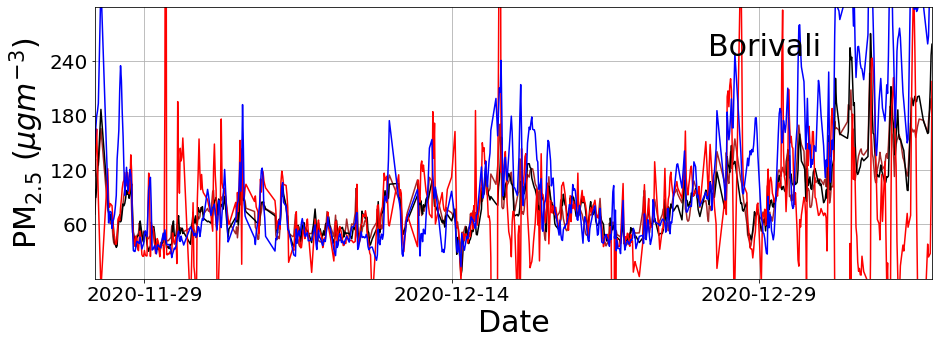

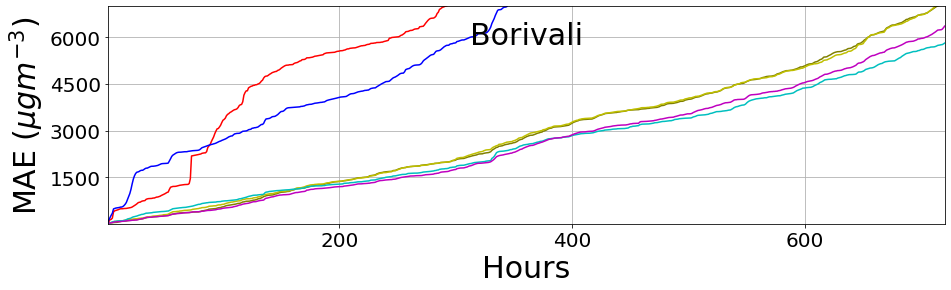

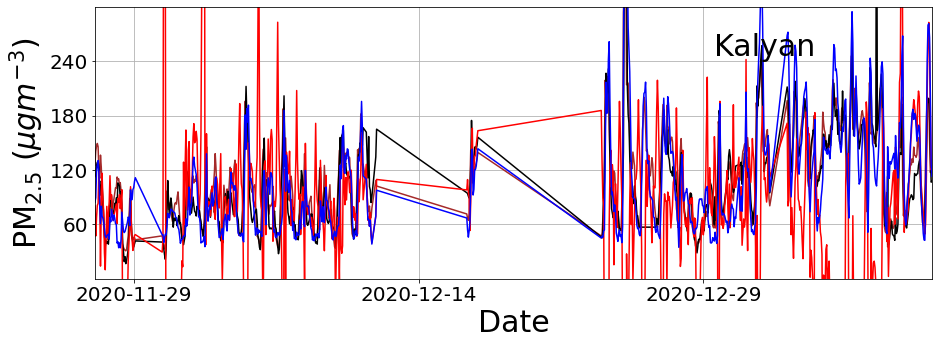

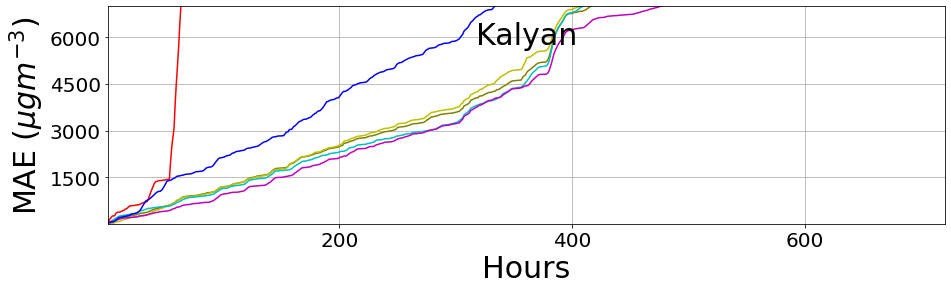

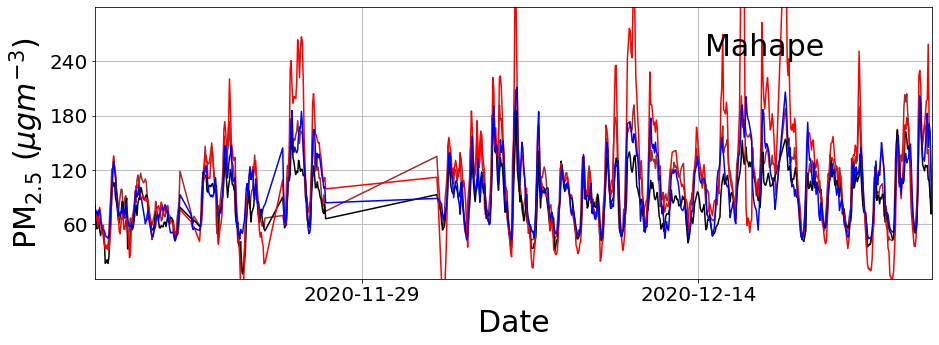

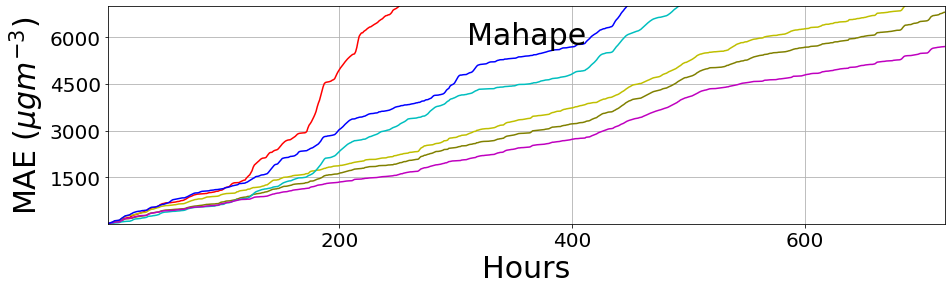

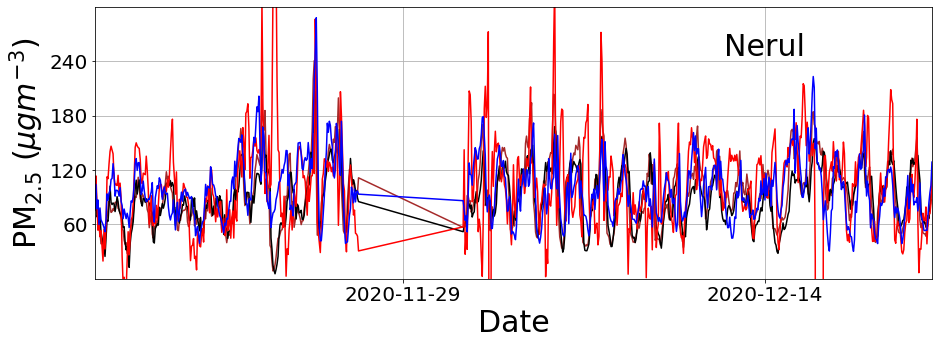

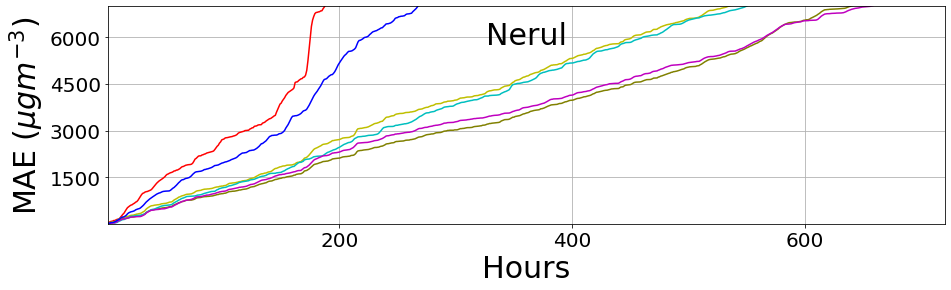

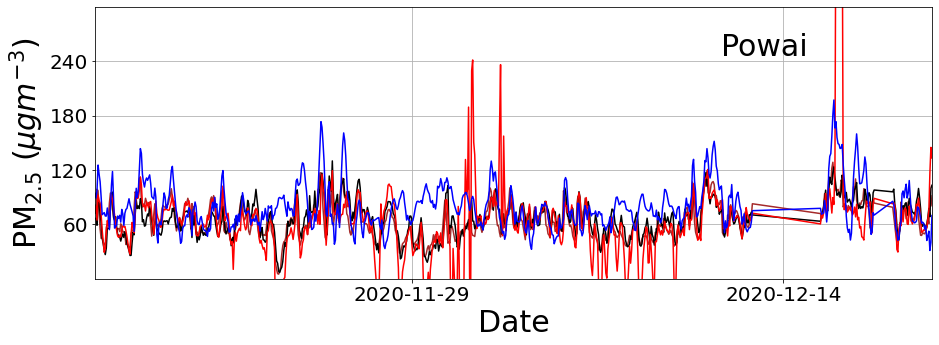

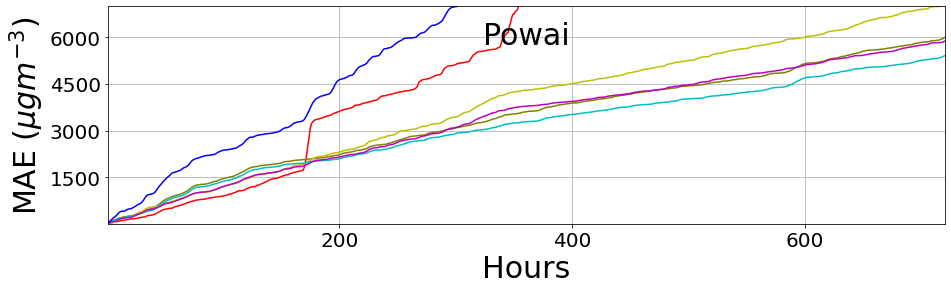

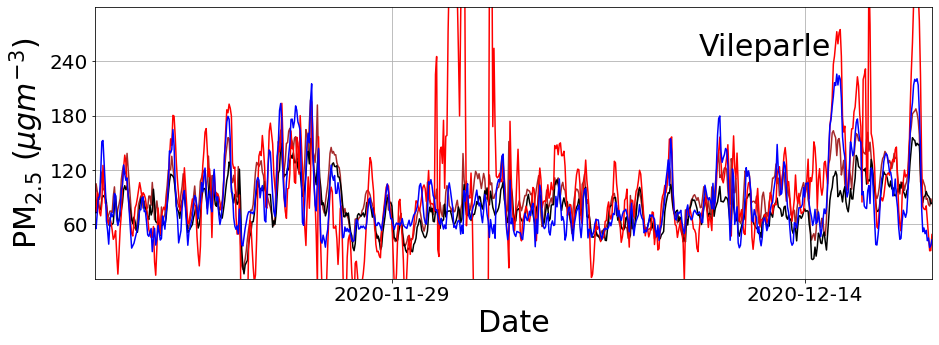

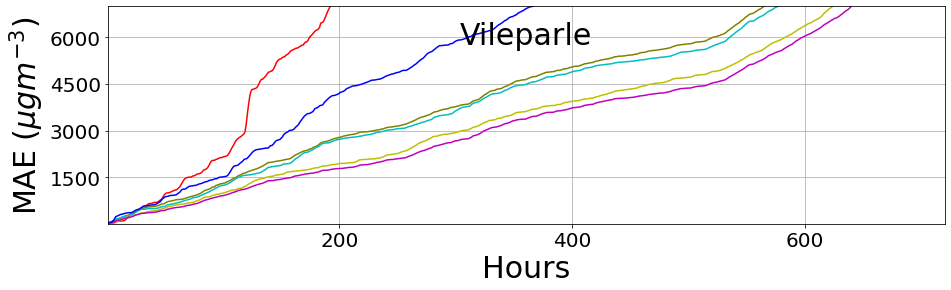

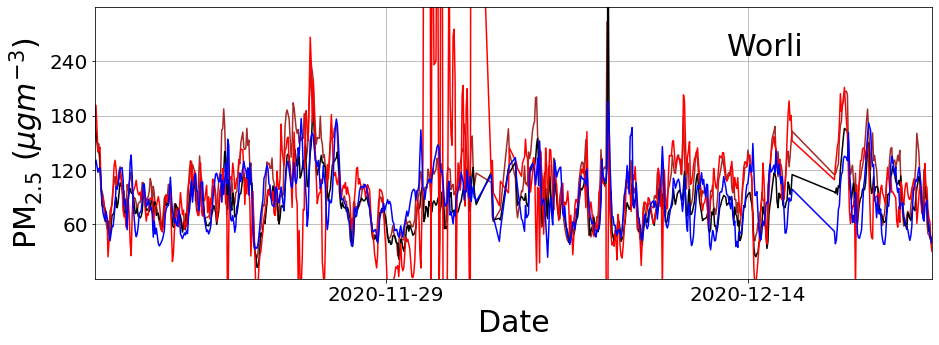

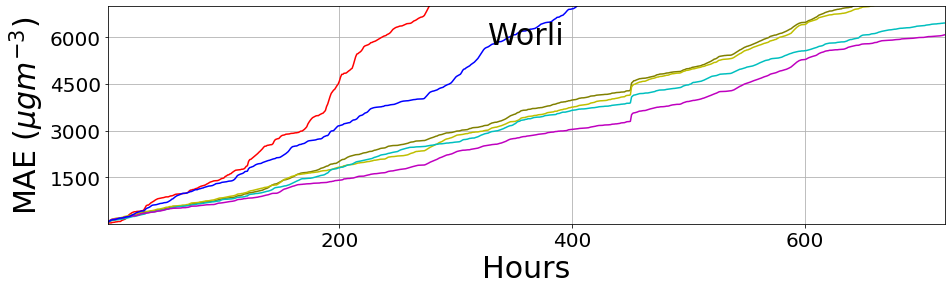

In [3]:
name_list = ['Borivali','Kalyan','Mahape','Nerul','Powai','Vileparle','Worli']
target_testing_scratch(name_list)